Data can be found here: https://www.kaggle.com/datasets/uciml/faulty-steel-plates

# EDA

## Statistics

In [1]:
import io
import contextlib
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from pytorch_tabnet.tab_model import TabNetClassifier
import warnings
from utils import fttransformer, evaluate_synthetic, ctgan_oversampling, smotenc, nn_optimization
from utils.general import rounded_mean, metrics_of_prediction, plot_cm, scale_df, preprocess_df
import optuna
import umap
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

ModuleNotFoundError: No module named 'tensorflow'

load and display the dataset

In [ ]:
df = pd.read_csv('csv/faults.csv')
df.head()

General infos

In [ ]:
df.info()

In [ ]:
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} features, while having {df.isnull().sum().sum()} null values.')
print(f'Features have data type {df.dtypes.unique()[0]} and {df.dtypes.unique()[1]}.')

Statistics about the features

In [ ]:
df.drop(['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults'], axis = 1).describe().T

Lower the name of the columns

In [2]:
df.columns = map(str.lower, df.columns)

NameError: name 'df' is not defined

Create a column encoding the anomalies features


In [87]:
# list of the anomalies features present in the dataset
target_cols = ['pastry', 'z_scratch', 'k_scatch', 'stains', 'dirtiness', 'bumps', 'other_faults']

# list of the features of the steel plates
feat_col = [x for x in df.columns if x not in target_cols]

# mapper for the encoding
enc_dict = {'pastry' : 0, 
            'z_scratch' : 1,
            'k_scatch' : 2, 
            'stains' : 3,
            'dirtiness' : 4, 
            'bumps' : 5, 
            'other_faults' : 6} 

df['anomaly'] = pd.from_dummies(df[target_cols]).replace(enc_dict)
df.drop(target_cols, axis = 1, inplace = True)
# remove troublesome outlier
df.drop(391, inplace = True)

## Histograms of the features

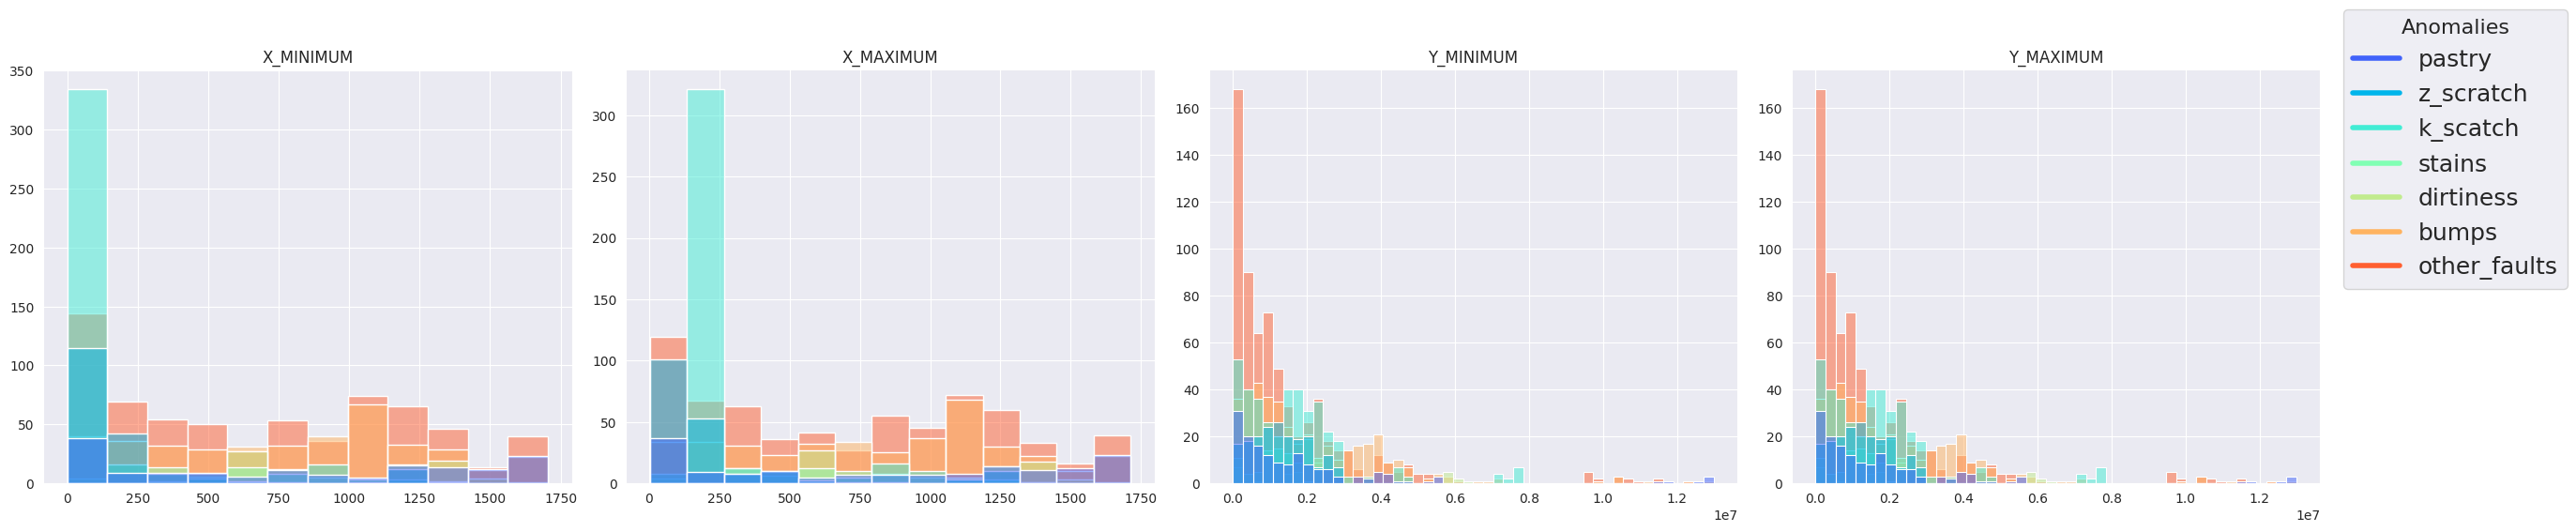

In [88]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

palette_hist = sns.color_palette('rainbow', n_colors = len(df['anomaly'].unique()))
hue_order = df['anomaly'].unique()

colors = sns.color_palette('rainbow', len(target_cols))
handles = [plt.Line2D([0], [0], color = colors[i], lw = 4, label = str(target_cols[i])) for i in range(len(target_cols))]

for index, col in enumerate(feat_col[:4]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

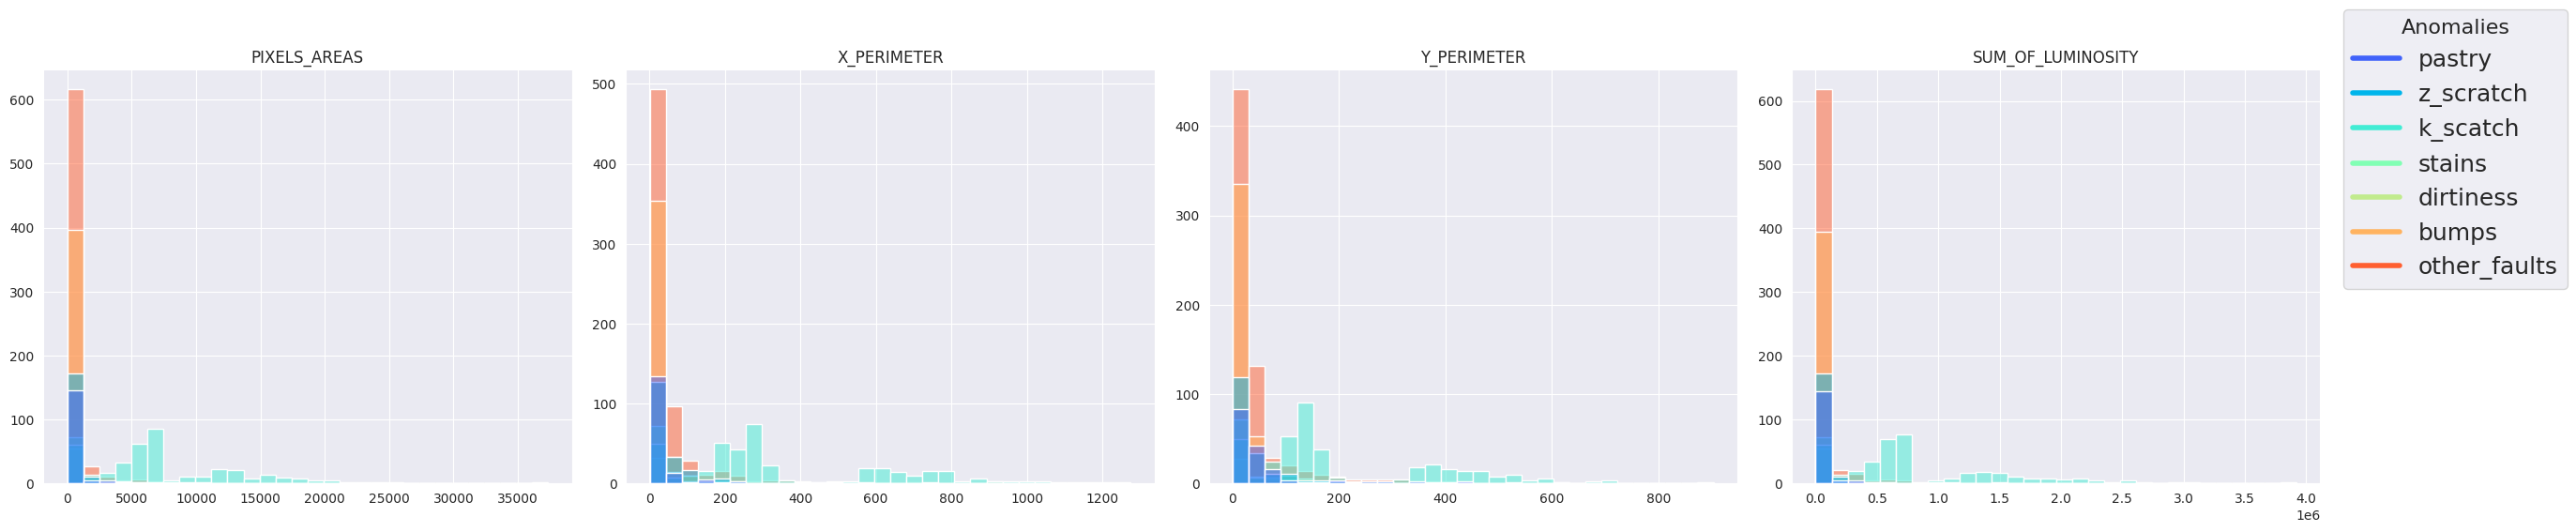

In [89]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[4:8]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False, bins = 30)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('') 

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

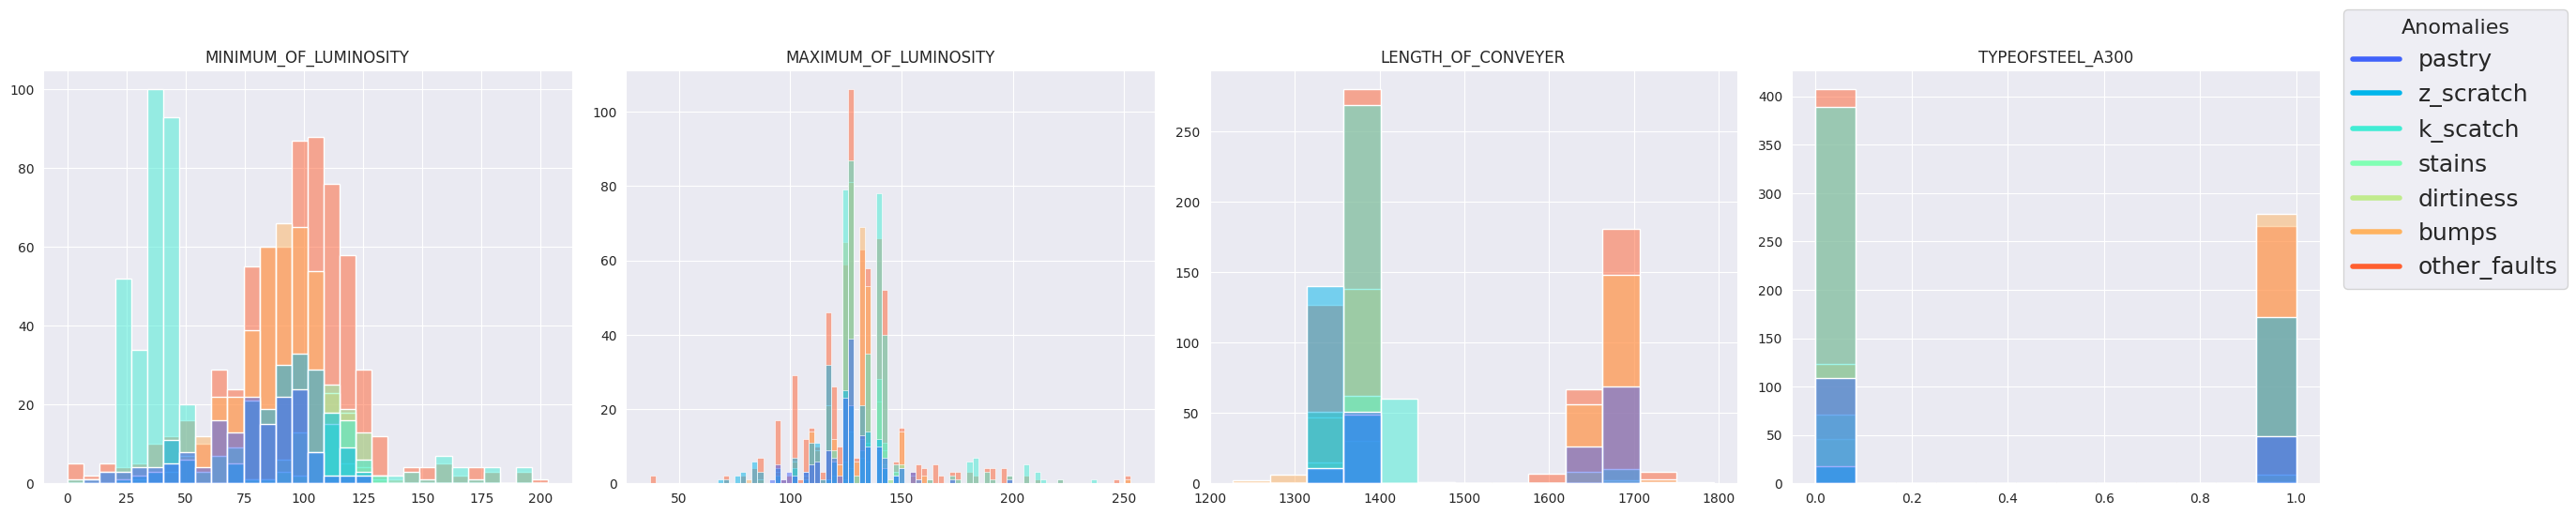

In [90]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[8:12]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

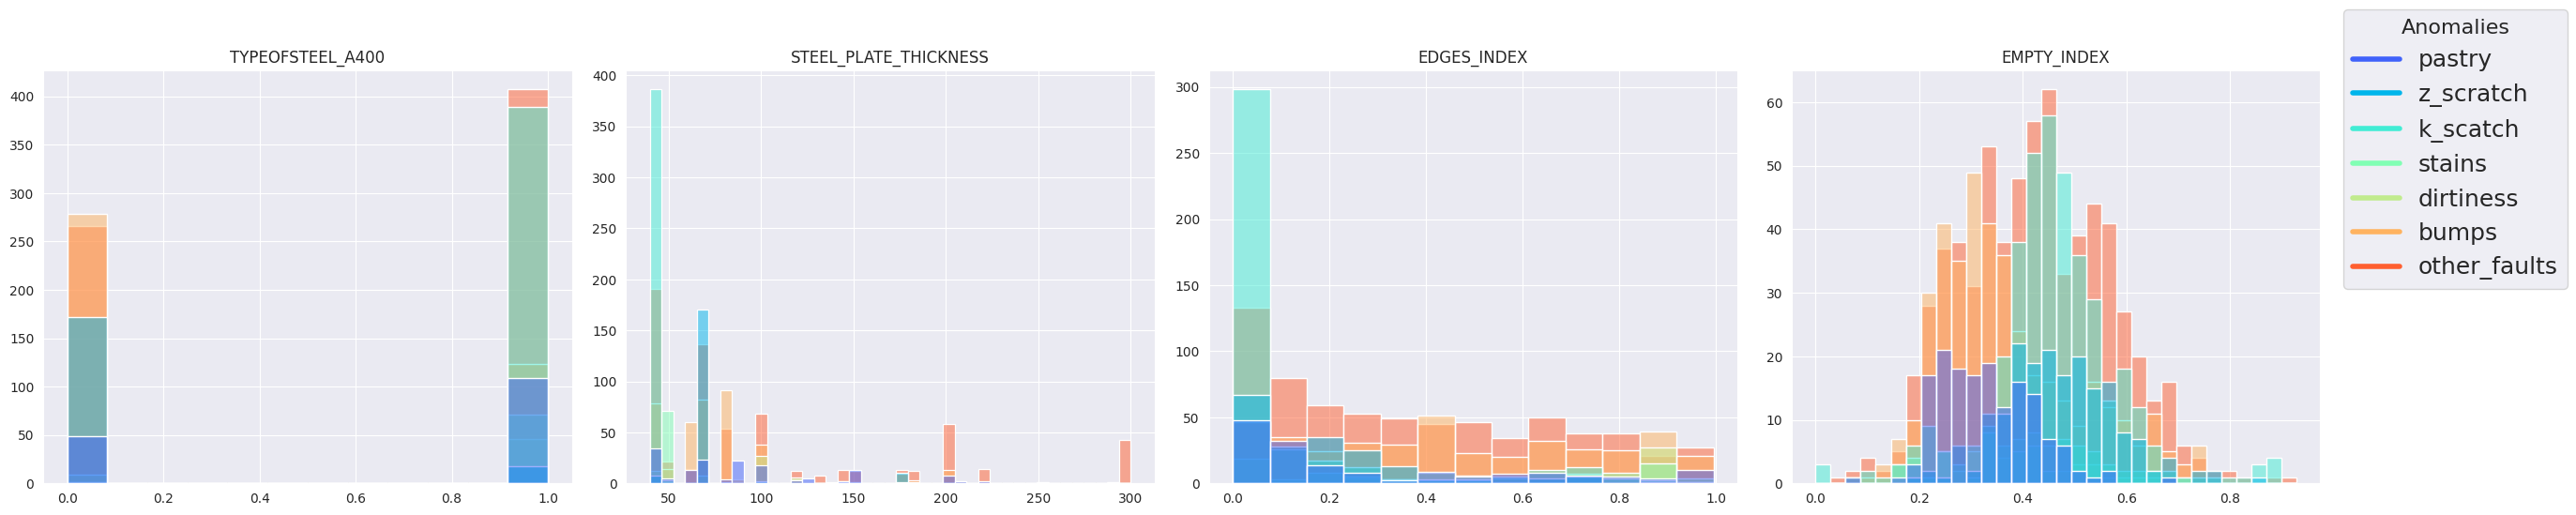

In [91]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[12:16]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

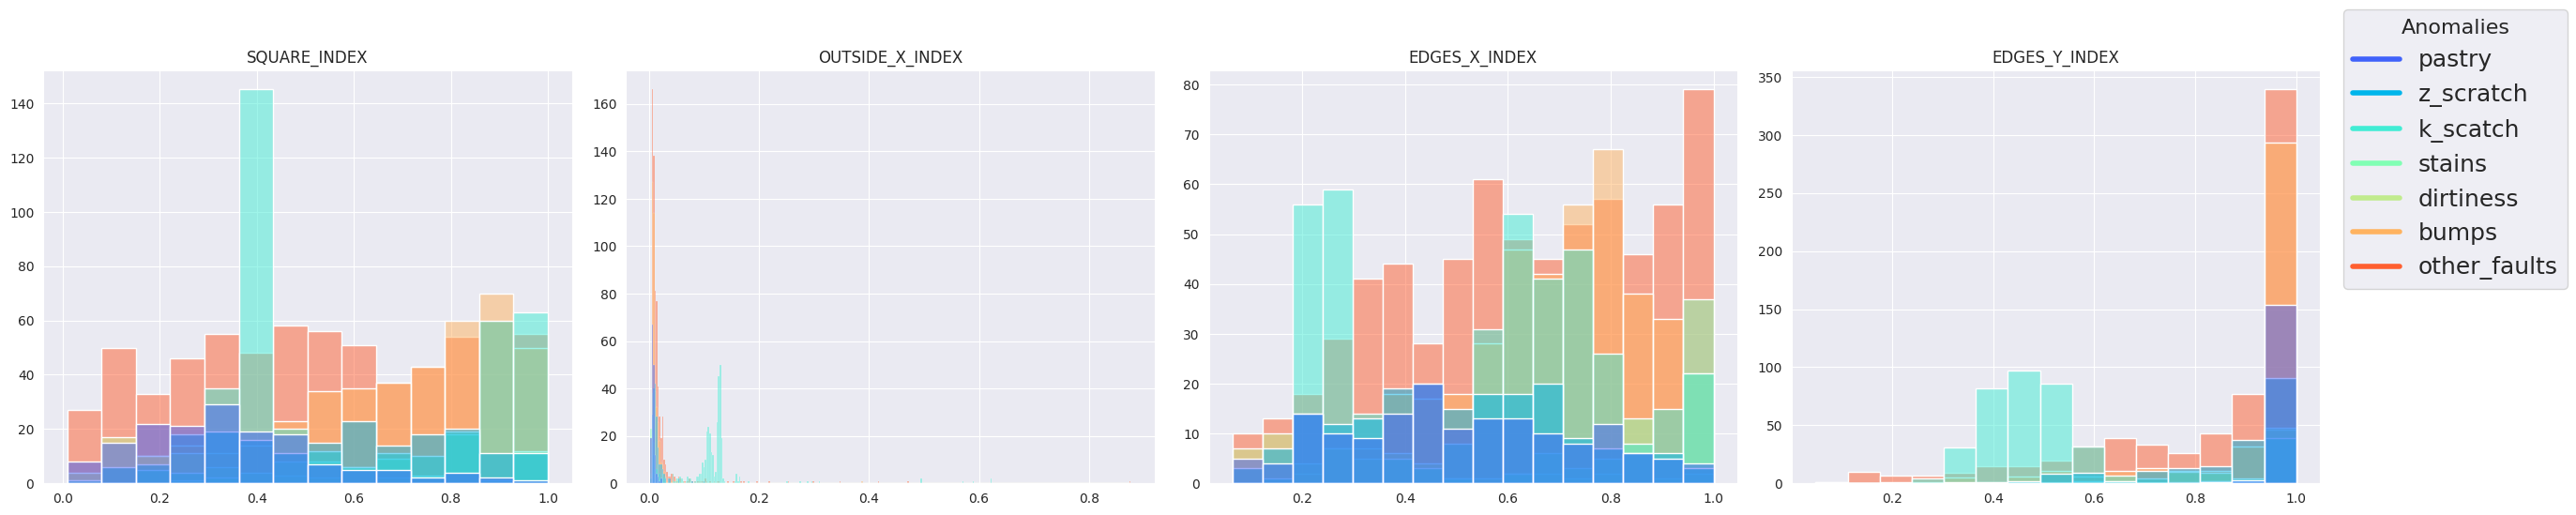

In [92]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[16:20]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

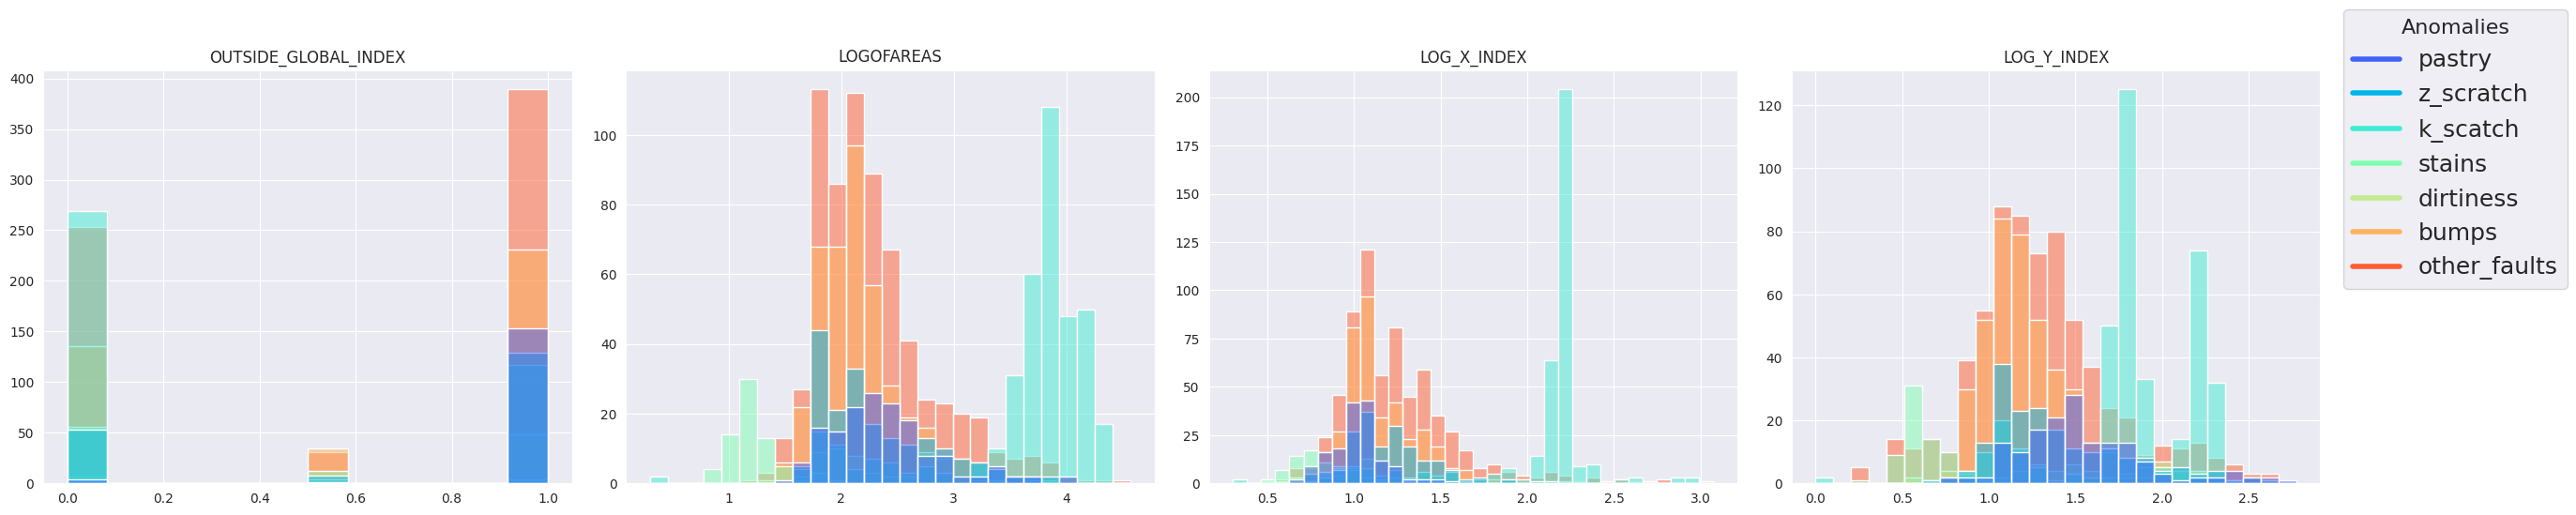

In [93]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[20:24]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

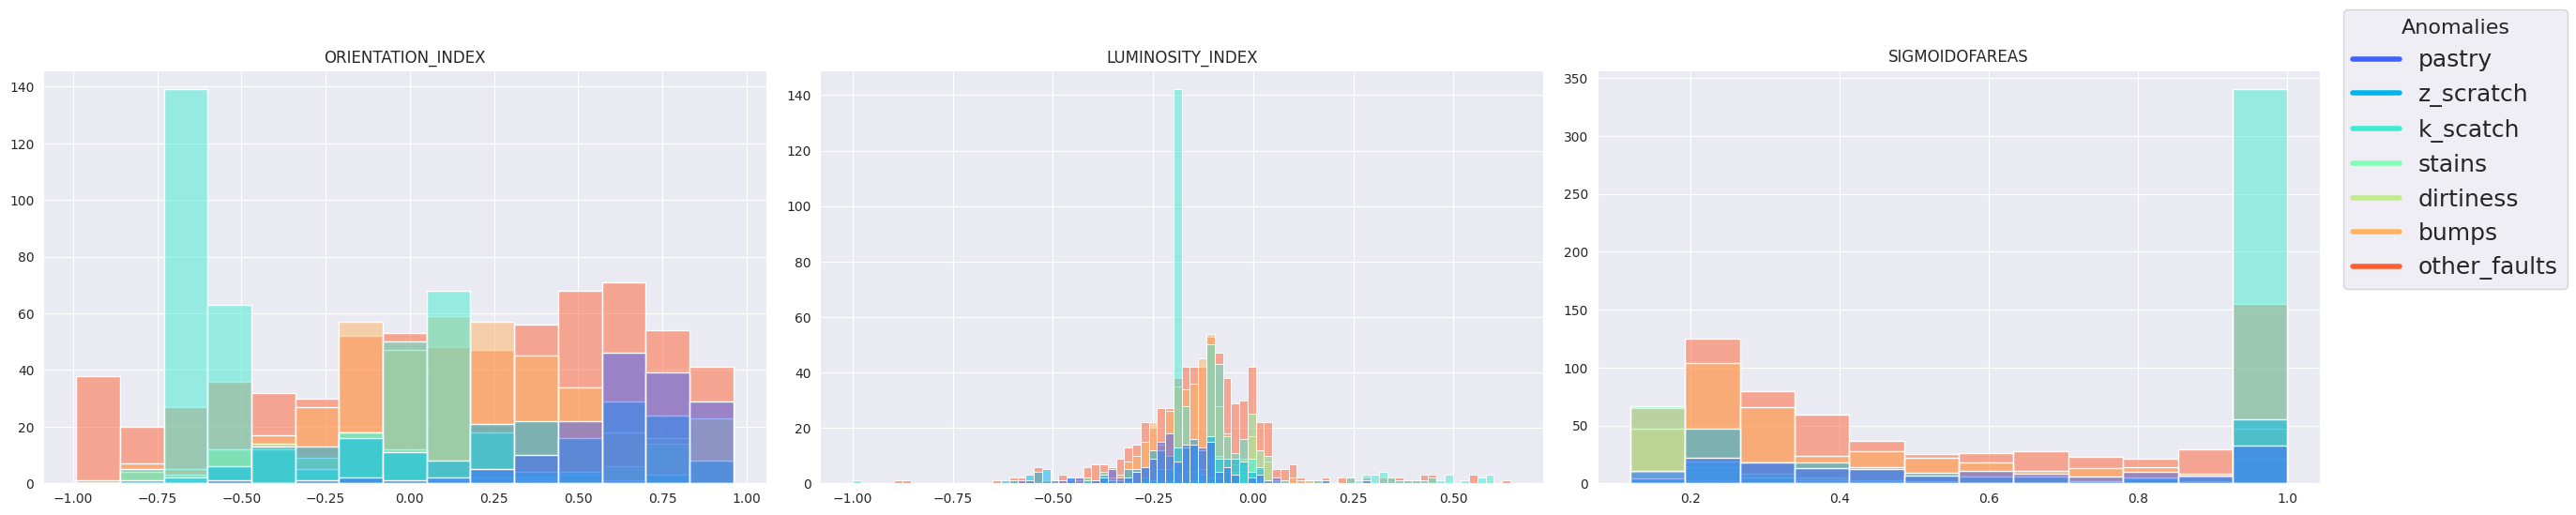

In [94]:
fig, ax = plt.subplots(1, 3, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[24:27]):
    sns.histplot(df, x = col, hue = 'anomaly', palette = palette_hist, hue_order = hue_order, ax = ax[index], legend = False)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

fig.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "center right", bbox_to_anchor = (1.1, 0.79), prop = {'size': 18}, title_fontsize = 16)

plt.show()

## Boxplots of the features

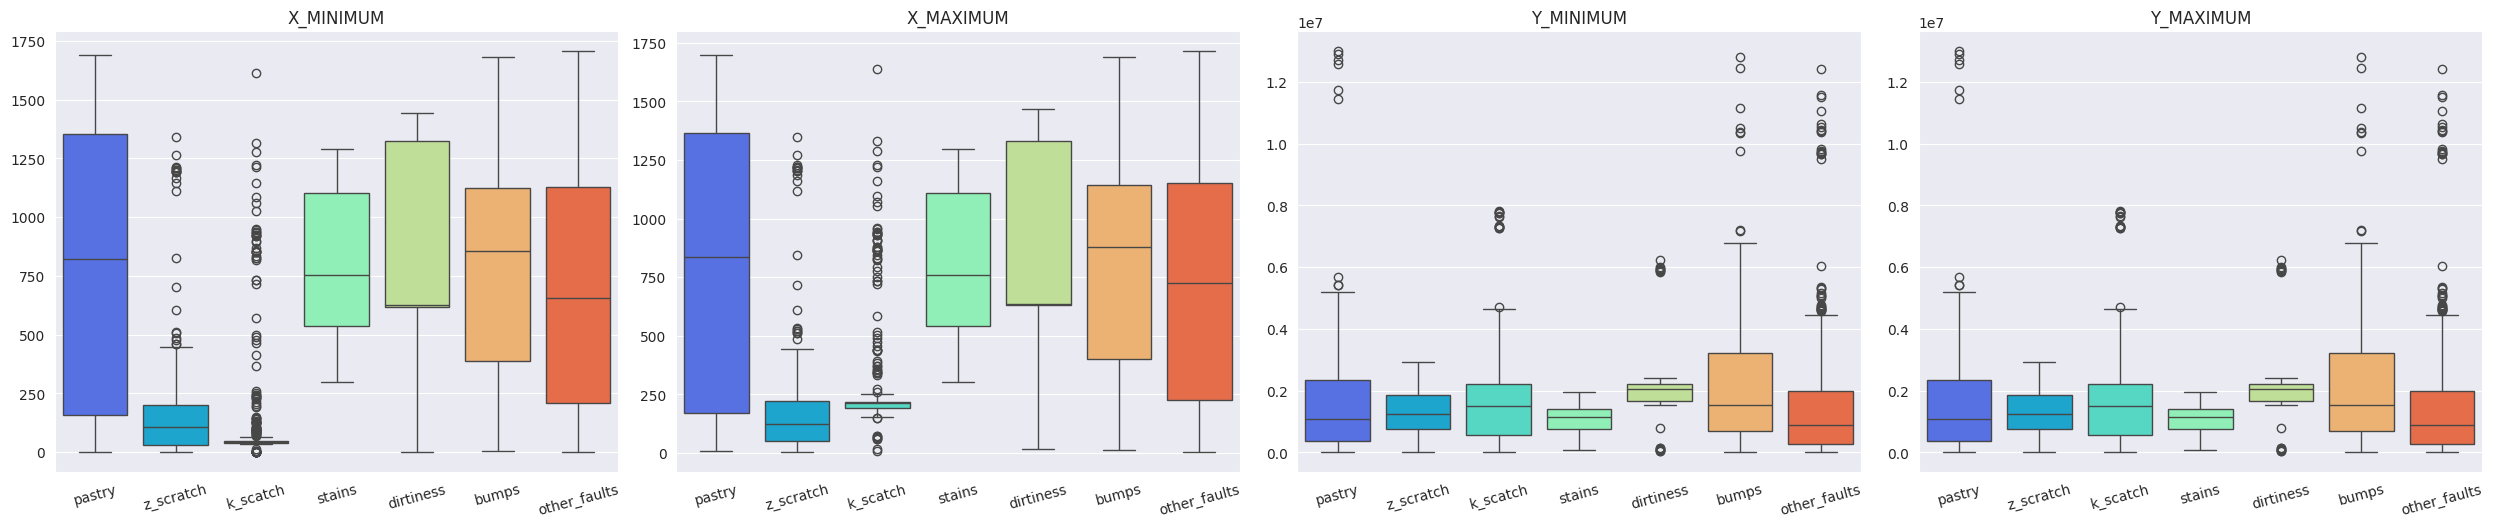

In [95]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[:4]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

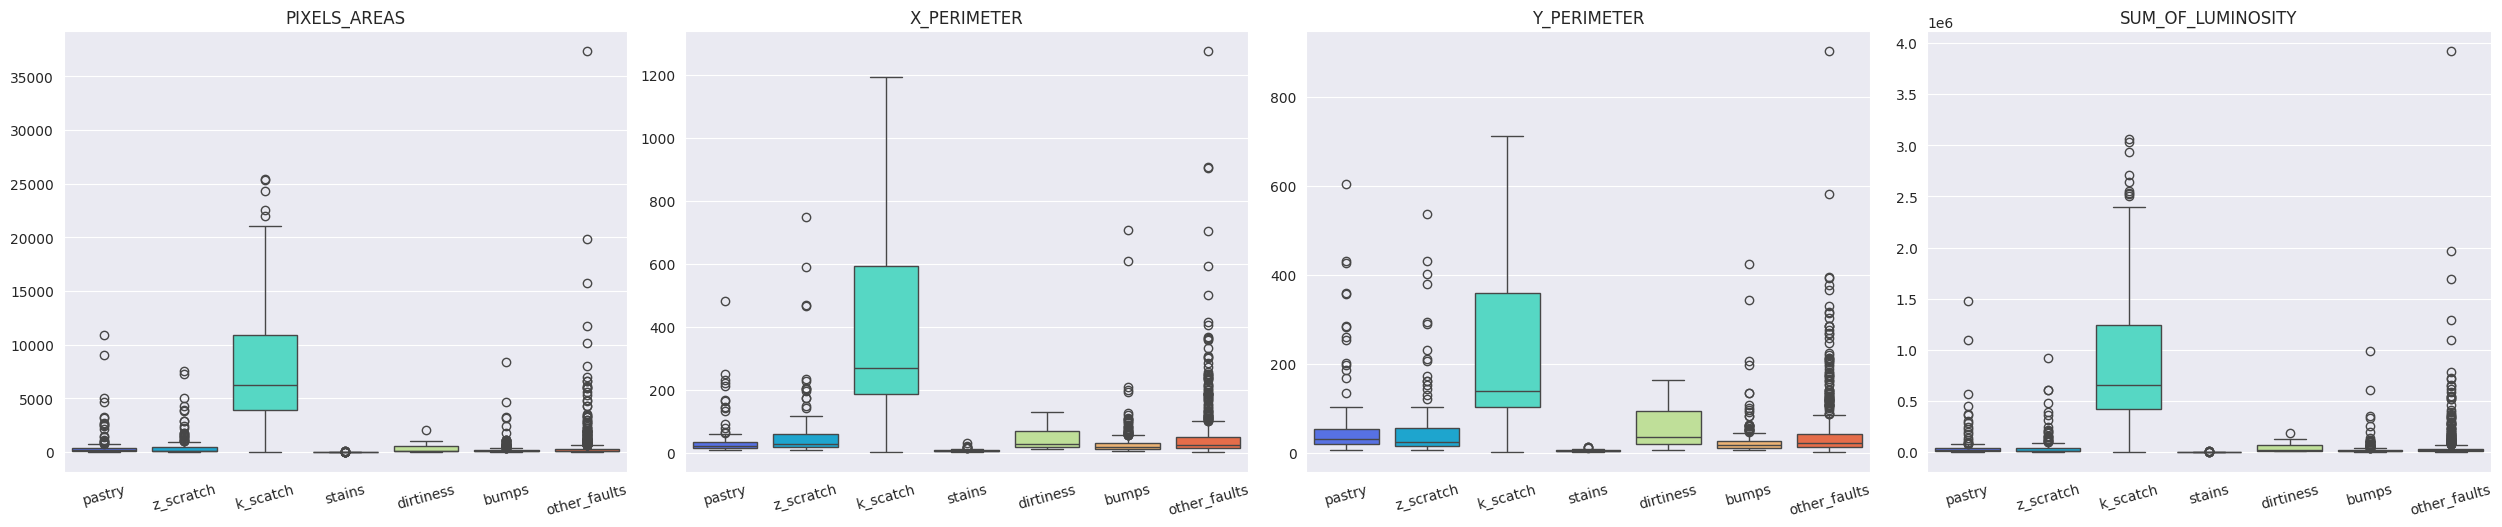

In [96]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[4:8]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

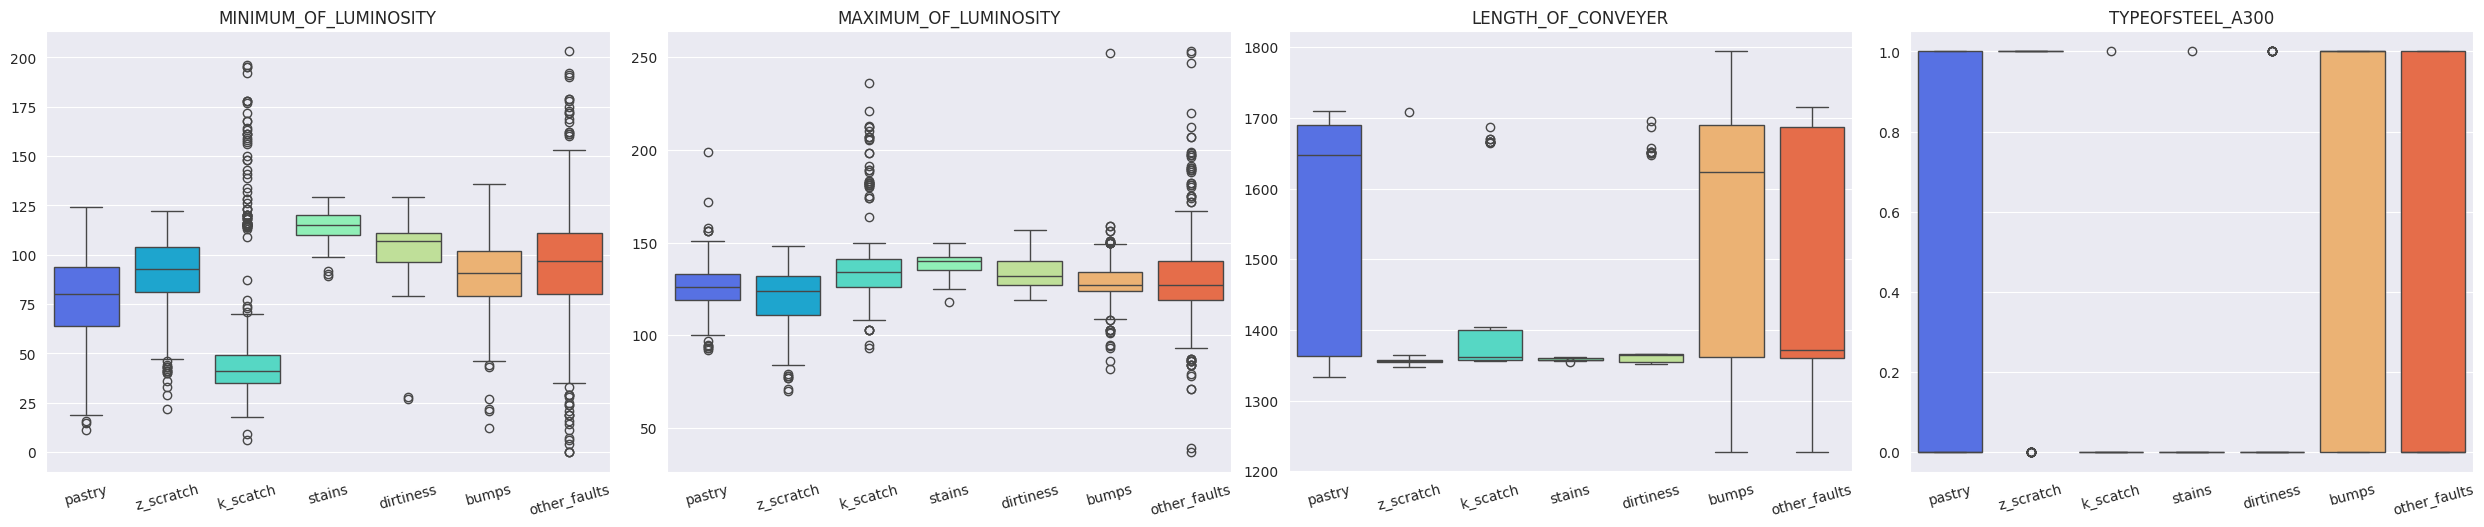

In [97]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[8:12]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

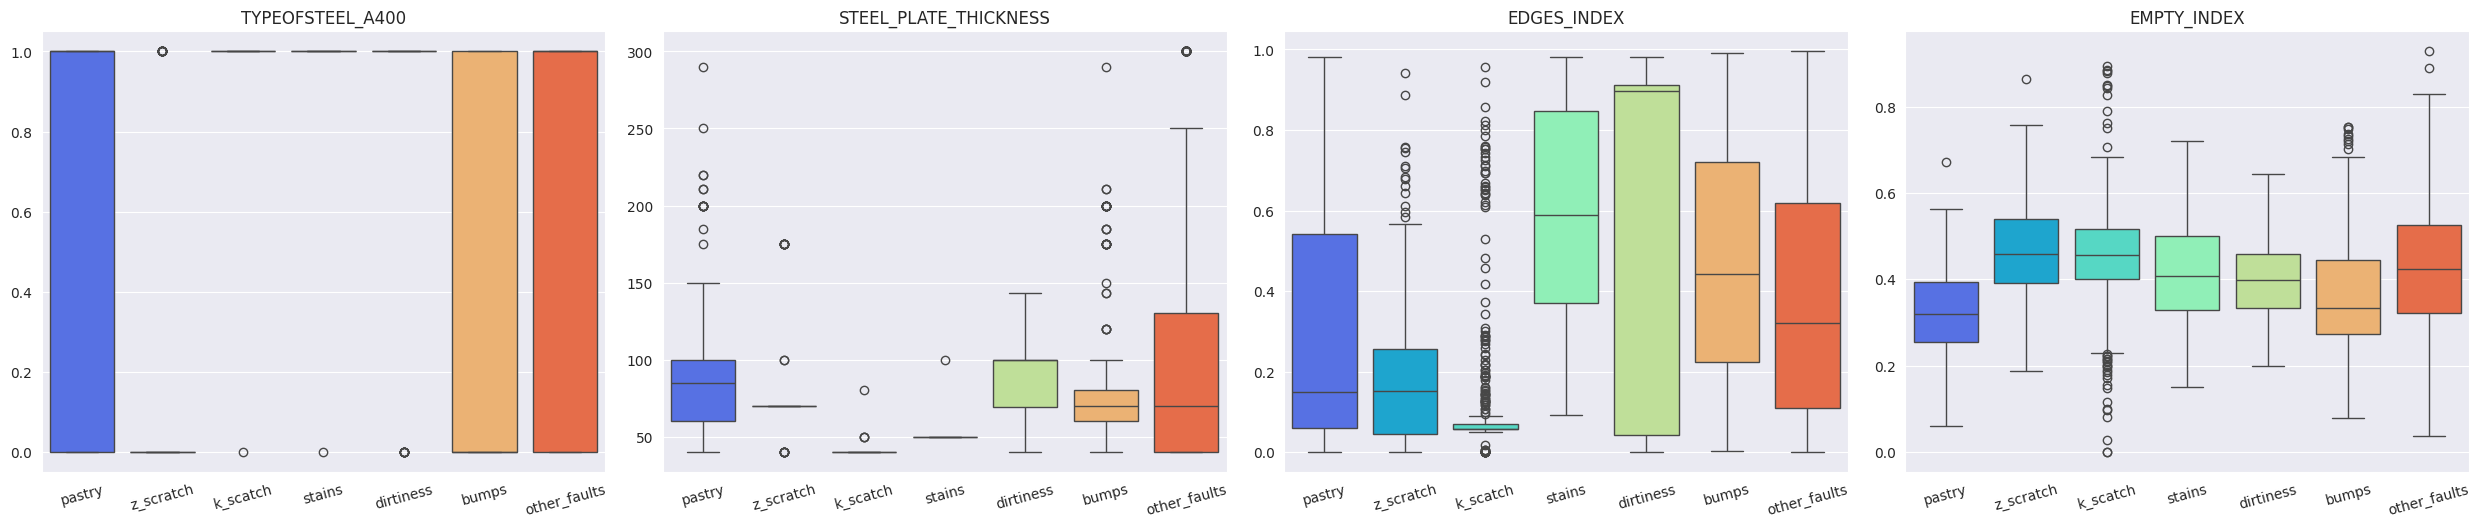

In [98]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[12:16]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

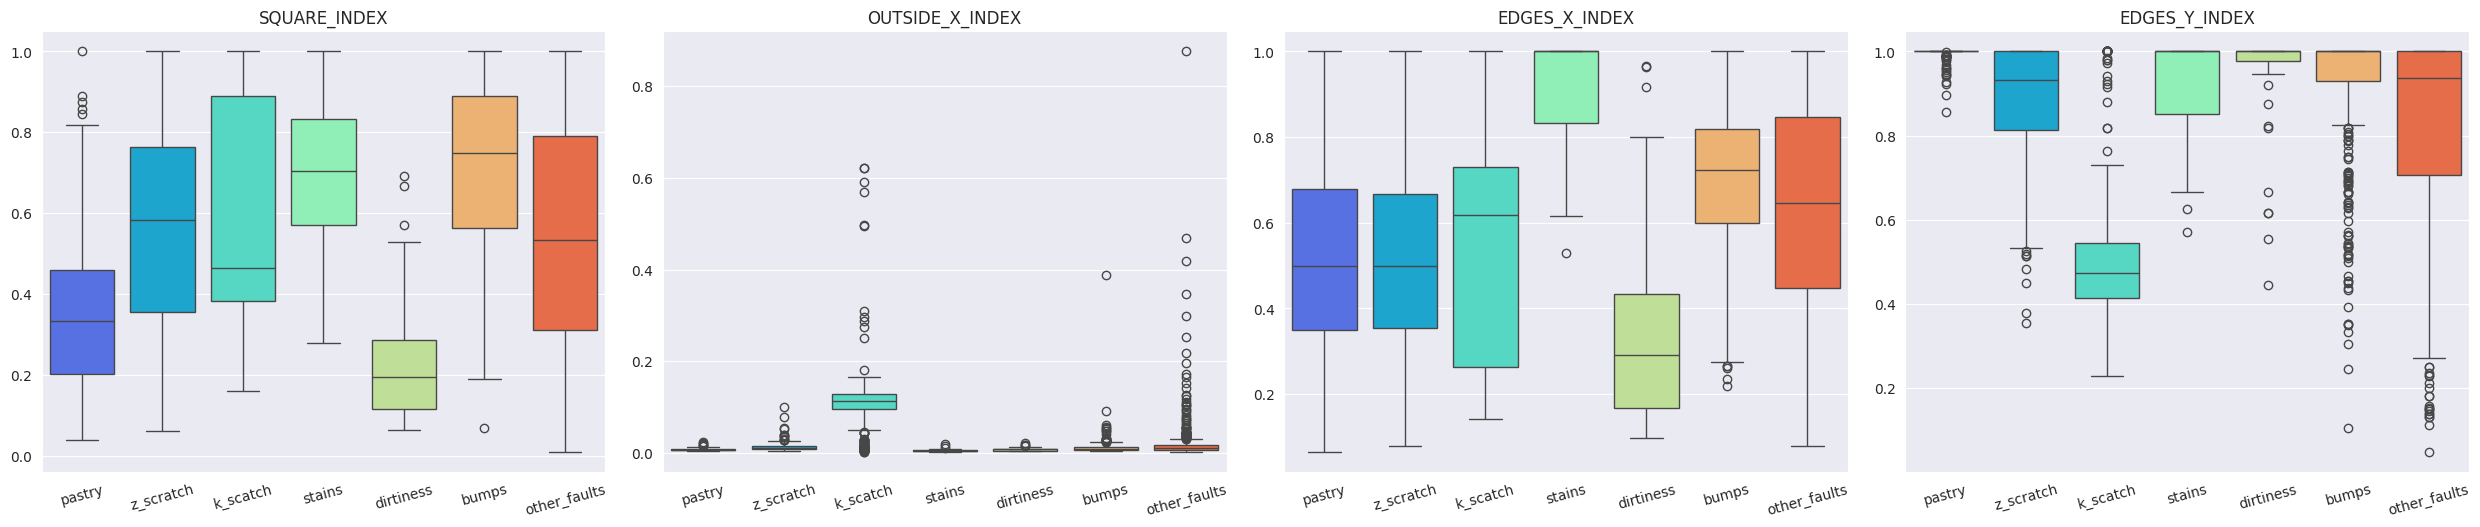

In [99]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[16:20]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

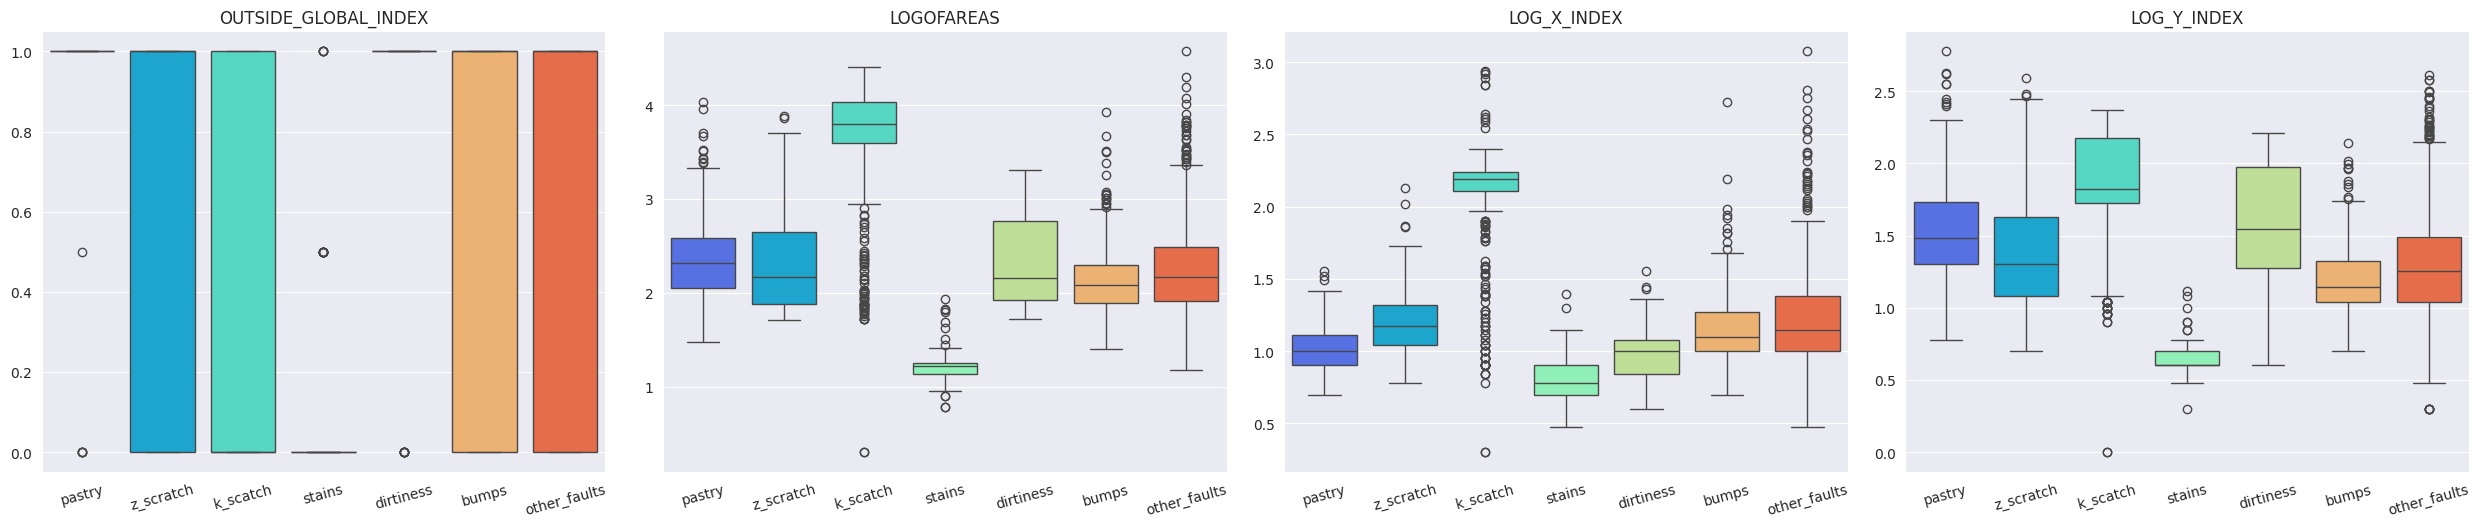

In [100]:
fig, ax = plt.subplots(1, 4, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[20:24]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

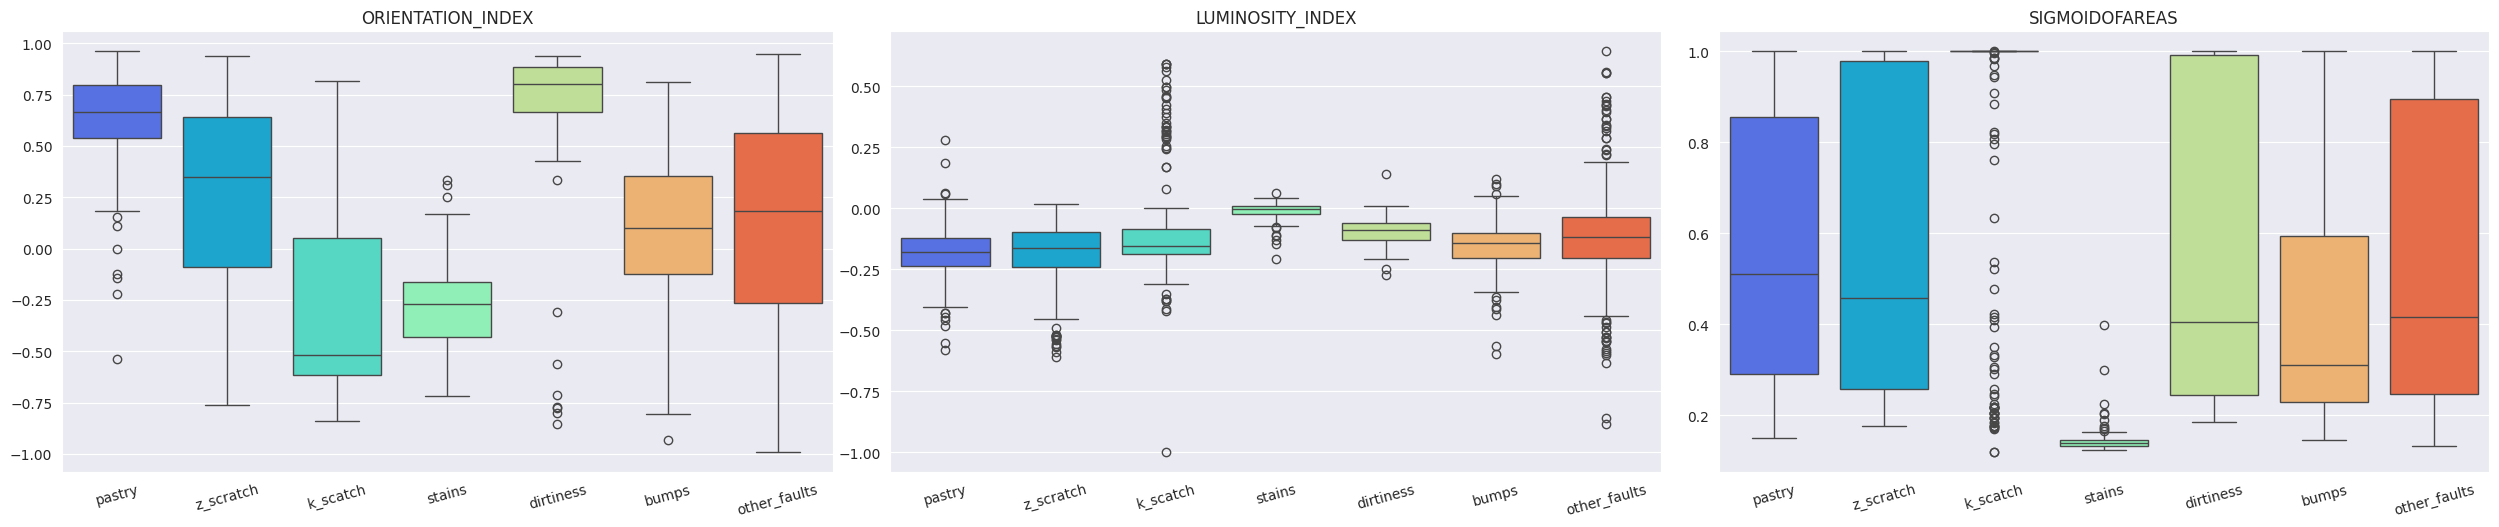

In [101]:
fig, ax = plt.subplots(1, 3, figsize = (25, 5))
fig.tight_layout()

for index, col in enumerate(feat_col[24:27]):
    sns.boxplot(data = df, x = 'anomaly', y = col, hue = 'anomaly', legend = False, palette = palette_hist, ax = ax[index])
    ax[index].set_xticks(ticks = [0, 1, 2, 3, 4, 5, 6], labels = target_cols, rotation = 15)
    ax[index].set_title(col.upper())
    ax[index].set_ylabel('')
    ax[index].set_xlabel('')

plt.show()

Check for binary features

In [102]:
for col in feat_col:
    if len(df[col].unique()) <= 2:
        print(f'Feature {col} has binary data (e.g. 0-1)')

# also check 'outside_global_index' feature
unique_ogi_feature = df['outside_global_index'].unique()
print(f'Feature outside_global_index has {len(unique_ogi_feature)} unique values, which are {str(unique_ogi_feature).strip("[").strip("]")}')

Feature typeofsteel_a300 has binary data (e.g. 0-1)
Feature typeofsteel_a400 has binary data (e.g. 0-1)
Feature outside_global_index has 3 unique values, which are 1.  0.5 0. 


# Correlation between features

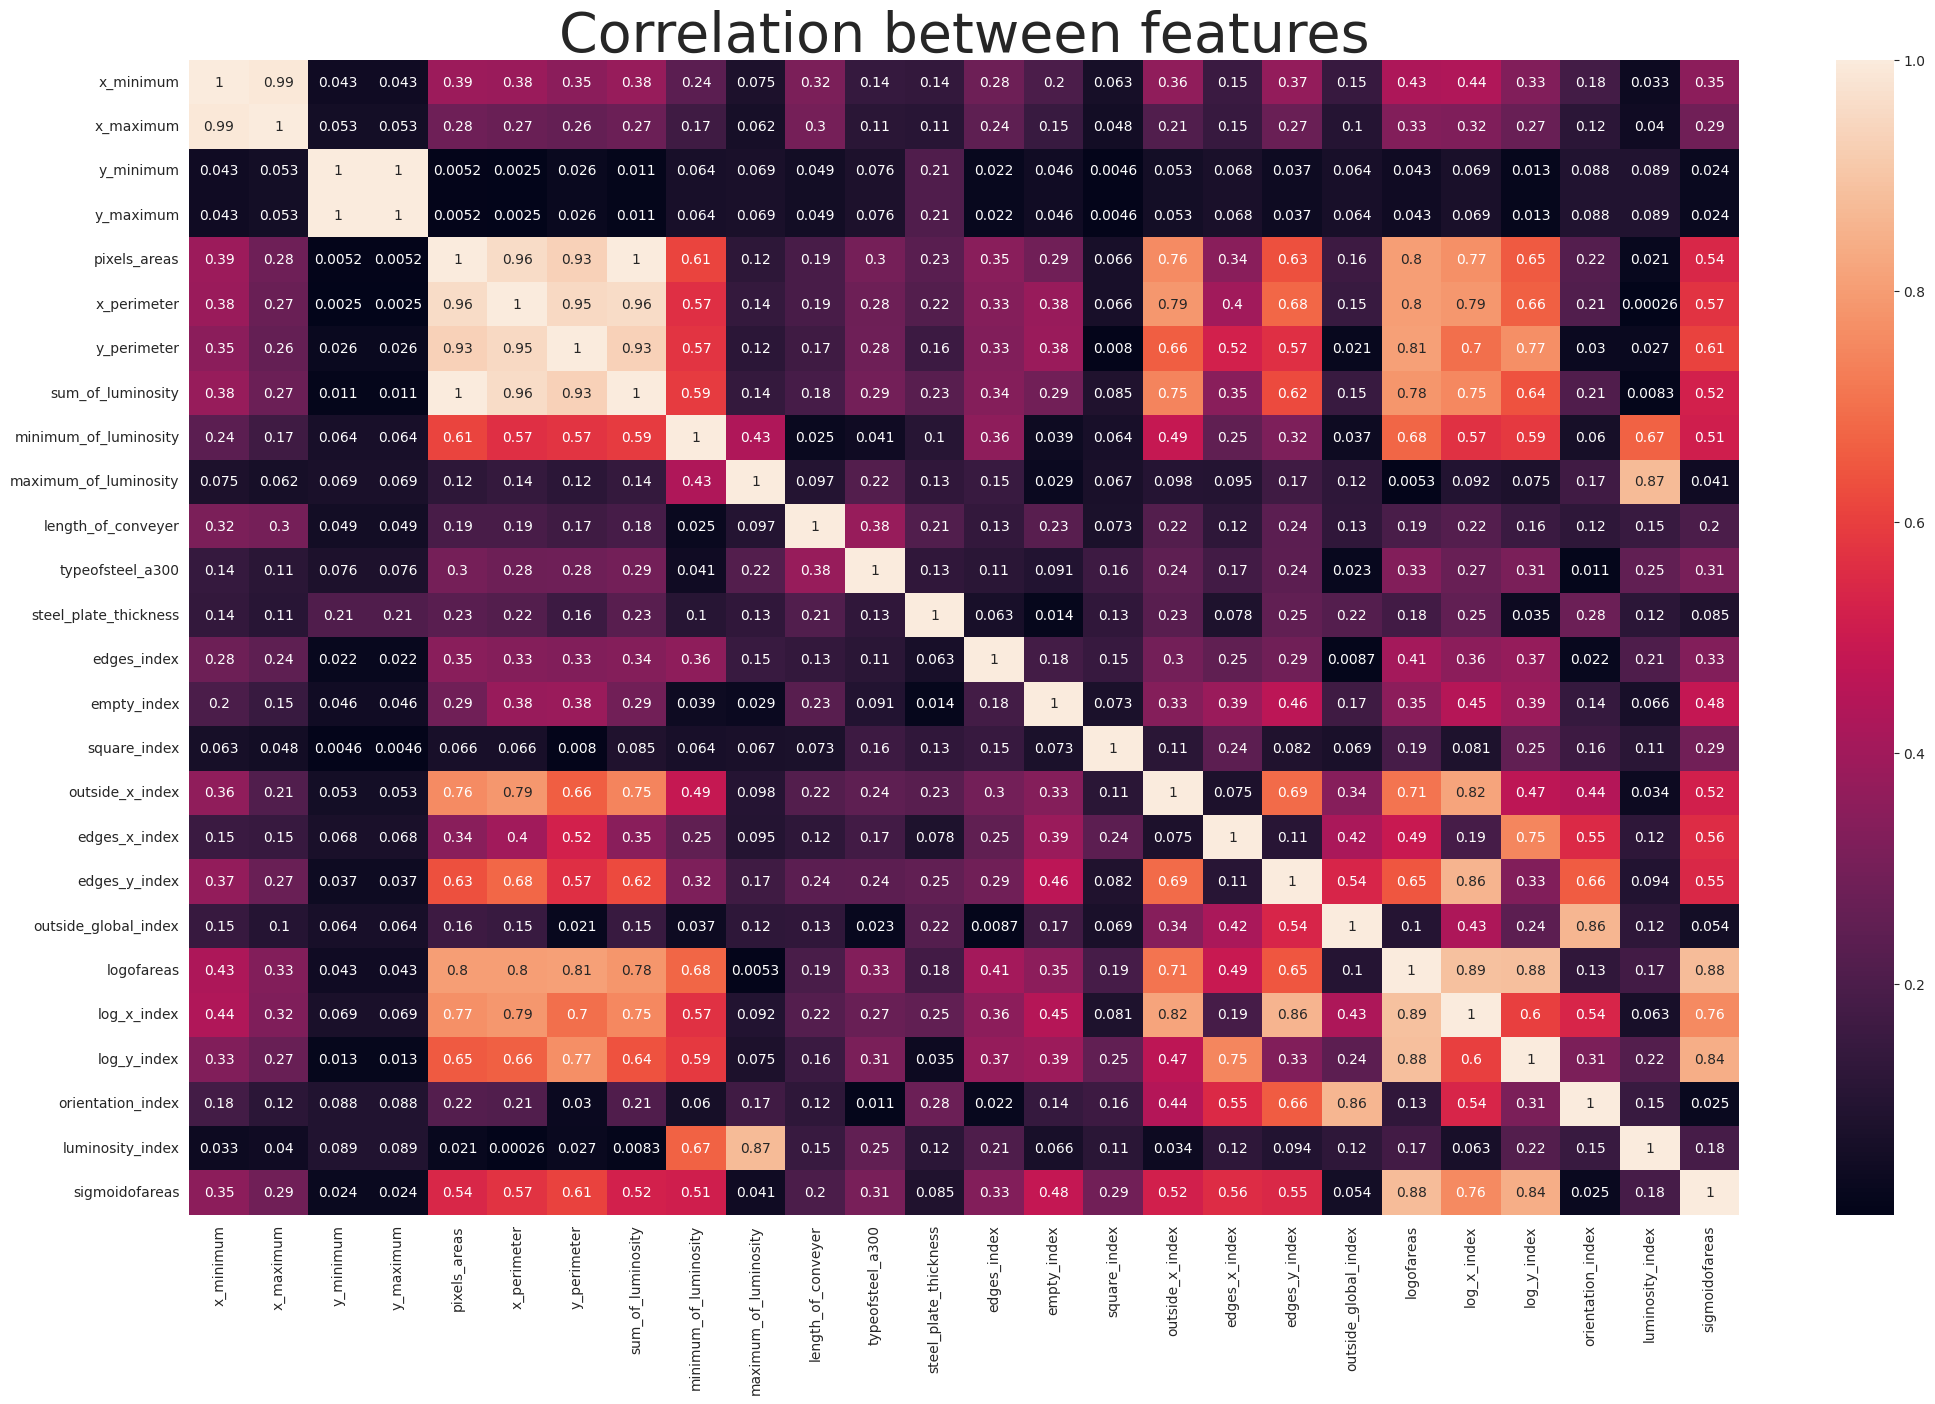

In [103]:
feat_col.remove('typeofsteel_a400')
corr = df[feat_col].corr().abs()

plt.figure(figsize = (25, 15))
plt.title('Correlation between features', fontsize = 40)
sns.heatmap(corr, annot = True)#, cbar = False)
#plt.savefig('correlation_matrix.png', dpi=300)
plt.show()

In [104]:
threshold = 0.9

mask = np.triu(np.ones(corr.shape), k=1)

# Find feature pairs with high correlation
high_corr_pairs = [
    (corr.index[i], corr.columns[j], corr.iloc[i, j])
    for i in range(corr.shape[0])
    for j in range(corr.shape[1])
    if mask[i, j] and corr.iloc[i, j] > threshold
]

high_corr_pairs = pd.DataFrame(high_corr_pairs).T
high_corr_pairs

0          1             2             3                  4  \
0  x_minimum  y_minimum  pixels_areas  pixels_areas       pixels_areas   
1  x_maximum  y_maximum   x_perimeter   y_perimeter  sum_of_luminosity   
2   0.988314        1.0      0.959504      0.929943           0.996767   

             5                  6                  7  
0  x_perimeter        x_perimeter        y_perimeter  
1  y_perimeter  sum_of_luminosity  sum_of_luminosity  
2     0.952089           0.960622             0.9321

We see that a lot of our features have high correlations between each others, particularly a lot of features have correlation higher than 0.33 (but even 0.7). This means we could use some feature engineering

Plot some relevant features (Pearson corr > 95%) so that we can better see their correlation

In [105]:
corr[corr > 0.95].replace({1.0 : np.nan}).dropna(how = 'all').dropna(axis = 1, how = 'all')

x_minimum  x_maximum  y_minimum  y_maximum  pixels_areas  \
x_minimum                NaN   0.988314        NaN        NaN           NaN   
x_maximum           0.988314        NaN        NaN        NaN           NaN   
y_minimum                NaN        NaN        NaN        1.0           NaN   
y_maximum                NaN        NaN        1.0        NaN           NaN   
pixels_areas             NaN        NaN        NaN        NaN           NaN   
x_perimeter              NaN        NaN        NaN        NaN      0.959504   
y_perimeter              NaN        NaN        NaN        NaN           NaN   
sum_of_luminosity        NaN        NaN        NaN        NaN      0.996767   

                   x_perimeter  y_perimeter  sum_of_luminosity  
x_minimum                  NaN          NaN                NaN  
x_maximum                  NaN          NaN                NaN  
y_minimum                  NaN          NaN                NaN  
y_maximum                  NaN          NaN                NaN  
pixels_areas          0.959504          NaN           0.996767  
x_perimeter                NaN     0.952089           0.960622  
y_perimeter           0.952089          NaN                NaN  
sum_of_luminosity     0.960622          NaN                NaN

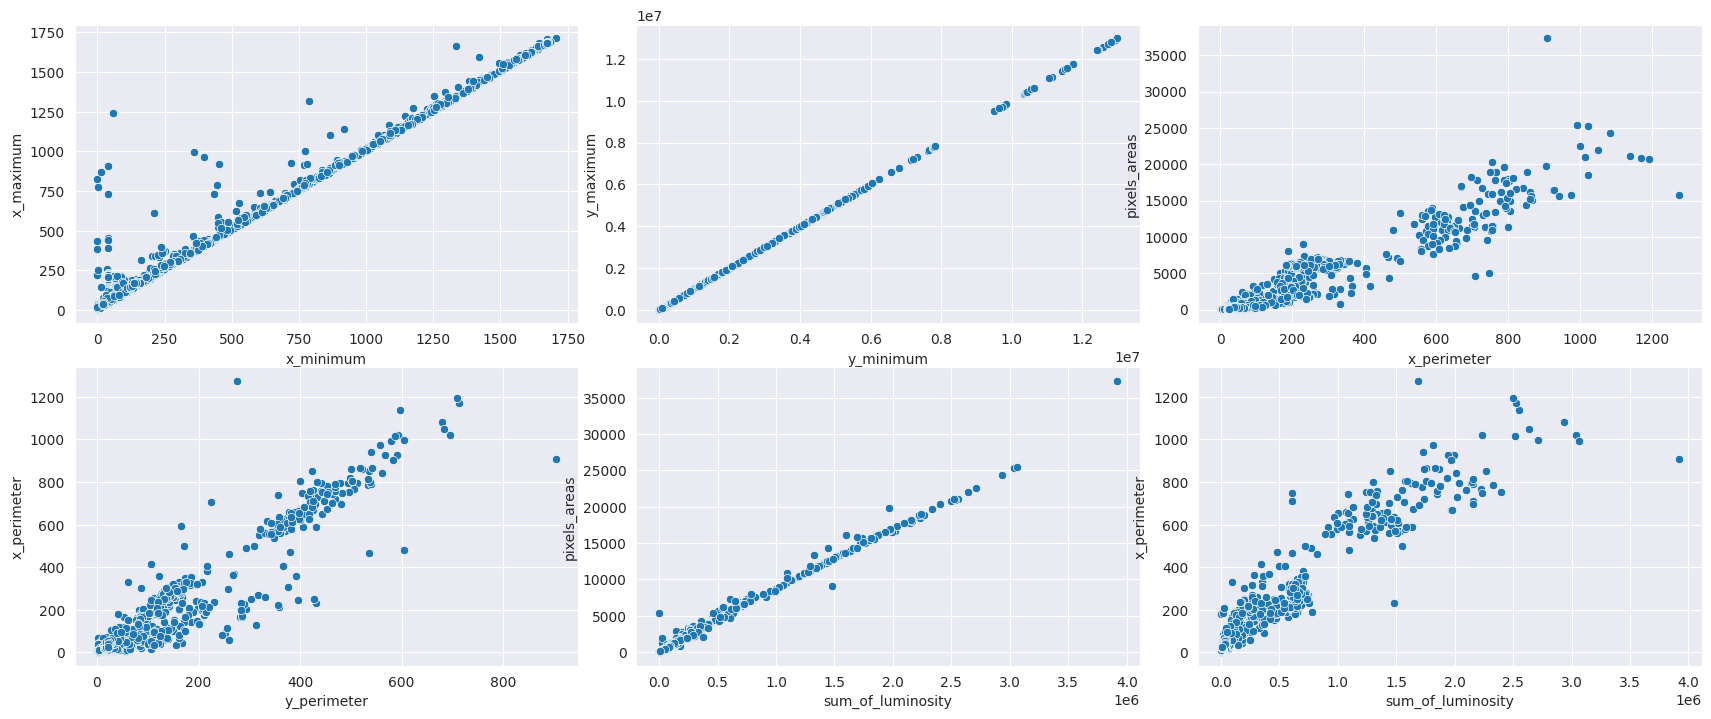

In [106]:
fig, ax = plt.subplots(2, 3, figsize = (17, 7))
fig.tight_layout()

sns.scatterplot(data = df, x = 'x_minimum', y = 'x_maximum', ax = ax[0][0])
sns.scatterplot(data = df, x = 'y_minimum', y = 'y_maximum', ax = ax[0][1])
sns.scatterplot(data = df, x = 'x_perimeter', y = 'pixels_areas', ax = ax[0][2])
sns.scatterplot(data = df, x = 'y_perimeter', y = 'x_perimeter', ax = ax[1][0])
sns.scatterplot(data = df, x = 'sum_of_luminosity', y = 'pixels_areas', ax = ax[1][1])
sns.scatterplot(data = df, x = 'sum_of_luminosity', y = 'x_perimeter', ax = ax[1][2])

plt.show()

We clearly see a strong linearity between the features. Unfortunately, except x_minimum/x_maximum and y_minimum/y_maximum, all the other features are on very different range of data. This means that we can't use simple mean for aggregating some of these features. First, we will need to normalize the data via z-score, and then aggregate some features.

Later in the notebook, dimensionality reduction through UMAP is applied. Since UMAP handles well non-linear relationships, it might not be worth it trying to aggregate all of the highly correlated features. However, we will aggregate the ones displayed in the last graph, since they have almost perfect linear correlation and we will lower the feature dimension, making UMAP more computationally efficient while loosing very little information.

# Balancing the classes/Normalize data

Display how the anomalies are divided in the dataset

In [107]:
anomaly_count = pd.DataFrame(df['anomaly'].value_counts()).sort_index()
anomaly_count.index = target_cols
anomaly_count

count
pastry          158
z_scratch       190
k_scatch        390
stains           72
dirtiness        55
bumps           402
other_faults    673

In [108]:
perc_first_3 = int(anomaly_count.loc[['other_faults', 'bumps', 'k_scatch']].sum()/anomaly_count.sum() * 100)
print(f'The first 3 anomalies count for {perc_first_3}% of the total anomalies')

The first 3 anomalies count for 75% of the total anomalies


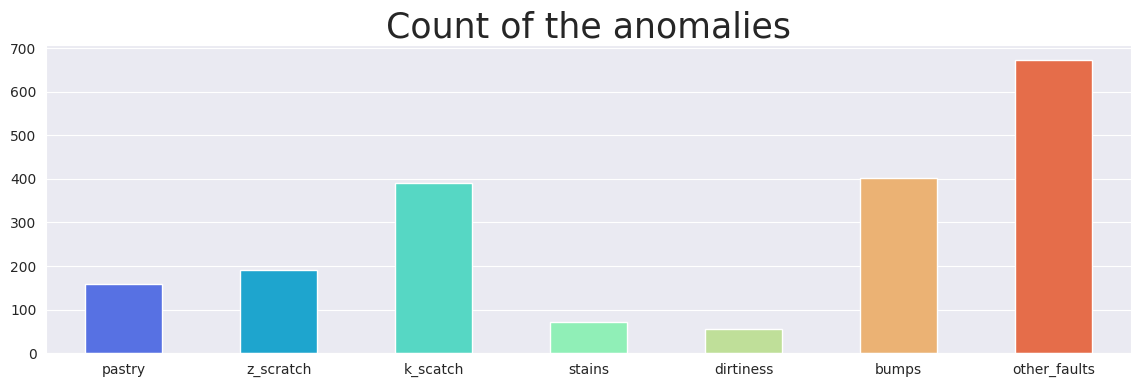

In [109]:
plt.figure(figsize = (14, 4))
sns.barplot(anomaly_count, x = anomaly_count.index, y = 'count', hue = anomaly_count.index, palette = 'rainbow', width = 0.5)
plt.title('Count of the anomalies', fontsize = 25)
plt.xlabel('')
plt.ylabel('')
plt.show()

## Smotenc

In [87]:
df_processed = preprocess_df(df)

df_smotenc = smotenc.smotenc_oversampling(df, ['outside_global_index', 'typeofsteel_a300'], 'anomaly')

bin_cols = ['typeofsteel_a300', 'outside_global_index', 'anomaly']


## CTGan

"Modeling Tabular data using Conditional GAN" paper: https://arxiv.org/abs/1907.00503

In [31]:
# Over-sample with CTGAN, bringing all the classes to 673 samples
df_ctgan = ctgan_oversampling.ctgan_oversampling(df_processed, bin_cols)

Processing anomaly category: 0
Processing anomaly category: 1
Processing anomaly category: 2
Processing anomaly category: 3
Processing anomaly category: 4
Processing anomaly category: 5
Processing anomaly category: 6
Skipping idx 6: No synthetic data needed.


## Smotenc-CTGan

In [33]:
# Over-sample with CTGAN the data balanced through SMOTENC, bringing all the classes to 2000 samples
df_smotenc_ctgan = ctgan_oversampling.ctgan_oversampling(df_smotenc, bin_cols, 1327, evaluate_data=False)

Processing anomaly category: 0
Processing anomaly category: 1
Processing anomaly category: 2
Processing anomaly category: 3
Processing anomaly category: 4
Processing anomaly category: 5
Processing anomaly category: 6


In [34]:
print('Anomaly count after oversampling with SMOTENC:\n', ctgan_oversampling.sample_count(df_smotenc), '\n-----------------------------')
print('Anomaly count after oversampling with CTGAN:\n', ctgan_oversampling.sample_count(df_ctgan), '\n-----------------------------')
print('Anomaly count after oversampling with SMOTENC-CTGAN:\n', ctgan_oversampling.sample_count(df_smotenc_ctgan), '\n-----------------------------')

Anomaly count after oversampling with SMOTENC:
          count
anomaly       
0          673
1          673
2          673
3          673
4          673
5          673
6          673 
-----------------------------
Anomaly count after oversampling with CTGAN:
          count
anomaly       
0          673
1          673
2          673
3          673
4          673
5          673
6          673 
-----------------------------
Anomaly count after oversampling with SMOTENC-CTGAN:
          count
anomaly       
0         2000
1         2000
2         2000
3         2000
4         2000
5         2000
6         2000 
-----------------------------


EVALUATE SYNTHETIC_DATA

In [35]:
df_smotenc = scale_df(df_smotenc, bin_cols)
df_ctgan = scale_df(df_ctgan, bin_cols).sample(frac=1)
df_smotenc_ctgan = scale_df(df_smotenc_ctgan, bin_cols).sample(frac=1)

df_smotenc.to_csv('csv/smotenc_normalized_steel_plates.csv')
df_ctgan.to_csv('csv/ctgan_normalized_steel_plates.csv')
df_smotenc_ctgan.to_csv('csv/smotenc_ctgan_normalized_steel_plates.csv')

In [110]:
paths = [
    'csv/smotenc_normalized_steel_plates.csv',
    'csv/ctgan_normalized_steel_plates.csv',
    'csv/smotenc_ctgan_normalized_steel_plates.csv'
]

method_names_list = ['SMOTENC', 'CTGAN', 'SMOTENC-CTGAN']

best_method = evaluate_synthetic.evaluate_synthetic_data(paths, method_names_list, 'csv/faults.csv')
print(f'The best model for creating synthesized data and balancing the classes is {best_method}')
#df_norm = df_smotenc_ctgan.copy()
df_norm = pd.read_csv('csv/smotenc_ctgan_normalized_steel_plates.csv', index_col=0, header=0).sample(frac=1)
df_norm.reset_index(drop = True, inplace = True)

Processing SMOTENC
Wasserstein distance for SMOTENC is: 0.11881381416250132
----------------------
Processing CTGAN
Wasserstein distance for CTGAN is: 0.1256797869082878
----------------------
Processing SMOTENC-CTGAN
Wasserstein distance for SMOTENC-CTGAN is: 0.11352520114466813
----------------------
The best model for creating synthesized data and balancing the classes is None


In [111]:
anomaly_count_res = pd.DataFrame(df_norm['anomaly'].value_counts()).sort_index()
anomaly_count_res.index = target_cols
anomaly_count_res

count
pastry         2000
z_scratch      2000
k_scatch       2000
stains         2000
dirtiness      2000
bumps          2000
other_faults   2000

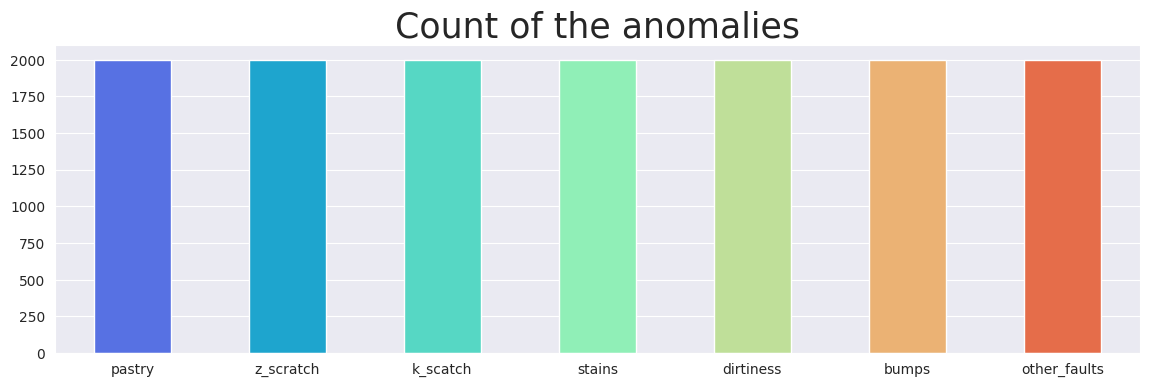

In [112]:
plt.figure(figsize = (14, 4))
sns.barplot(anomaly_count_res, x = anomaly_count_res.index, y = 'count', hue = anomaly_count_res.index, palette = 'rainbow', width = 0.5)
plt.title('Count of the anomalies', fontsize = 25)
plt.xlabel('')
plt.ylabel('')
plt.show()

In [113]:
# check for standardization
norm_dict = {col: [round(df_norm[col].mean()), round(df_norm[col].var())] for col in df_norm.columns}
display(pd.DataFrame(norm_dict, index=['Mean', 'Variance']).drop('anomaly', axis = 1))

x_minimum  x_maximum  y_minimum  y_maximum  pixels_areas  \
Mean              0          0          0          0             0   
Variance          1          1          1          1             1   

          x_perimeter  y_perimeter  sum_of_luminosity  minimum_of_luminosity  \
Mean                0            0                  0                      0   
Variance            1            1                  1                      1   

          maximum_of_luminosity  length_of_conveyer  steel_plate_thickness  \
Mean                          0                   0                      0   
Variance                      1                   1                      1   

          edges_index  empty_index  square_index  outside_x_index  \
Mean                0            0             0                0   
Variance            1            1             1                1   

          edges_x_index  edges_y_index  logofareas  log_x_index  log_y_index  \
Mean                  0              0           0            0            0   
Variance              1              1           1            1            1   

          orientation_index  luminosity_index  sigmoidofareas  \
Mean                      0                 0               0   
Variance                  1                 1               1   

          typeofsteel_a300  outside_global_index  
Mean                     0                     1  
Variance                 0                     0

Data has been correcly standardized since the only features that don't have mean = 0 and variance = 1 are the binary features

# Aggregate features

Aggregate features that have high correlation

In [114]:
df_norm['aggregate1'] = df_norm[['y_minimum', 'y_maximum']].mean(axis = 1)

df_norm['aggregate2'] = df_norm[['x_minimum', 'x_maximum']].mean(axis = 1)

df_norm['aggregate4'] = df_norm[['x_perimeter', 'pixels_areas']].mean(axis = 1)

df_norm['aggregate5'] = df_norm[['sum_of_luminosity', 'aggregate4']].mean(axis = 1)
df_norm.drop([], axis = 1, inplace = True)

df_norm['aggregate3'] = df_norm[['aggregate4', 'aggregate5']].mean(axis = 1)
df_norm.drop(['sum_of_luminosity', 'x_perimeter', 'y_minimum', 'y_maximum', 'x_minimum', 'x_maximum', 'pixels_areas', 'aggregate4', 'aggregate5'], axis = 1, inplace = True)

df_norm.dropna(inplace = True)

anomaly_col = df_norm.pop('anomaly')
df_norm['anomaly'] = anomaly_col

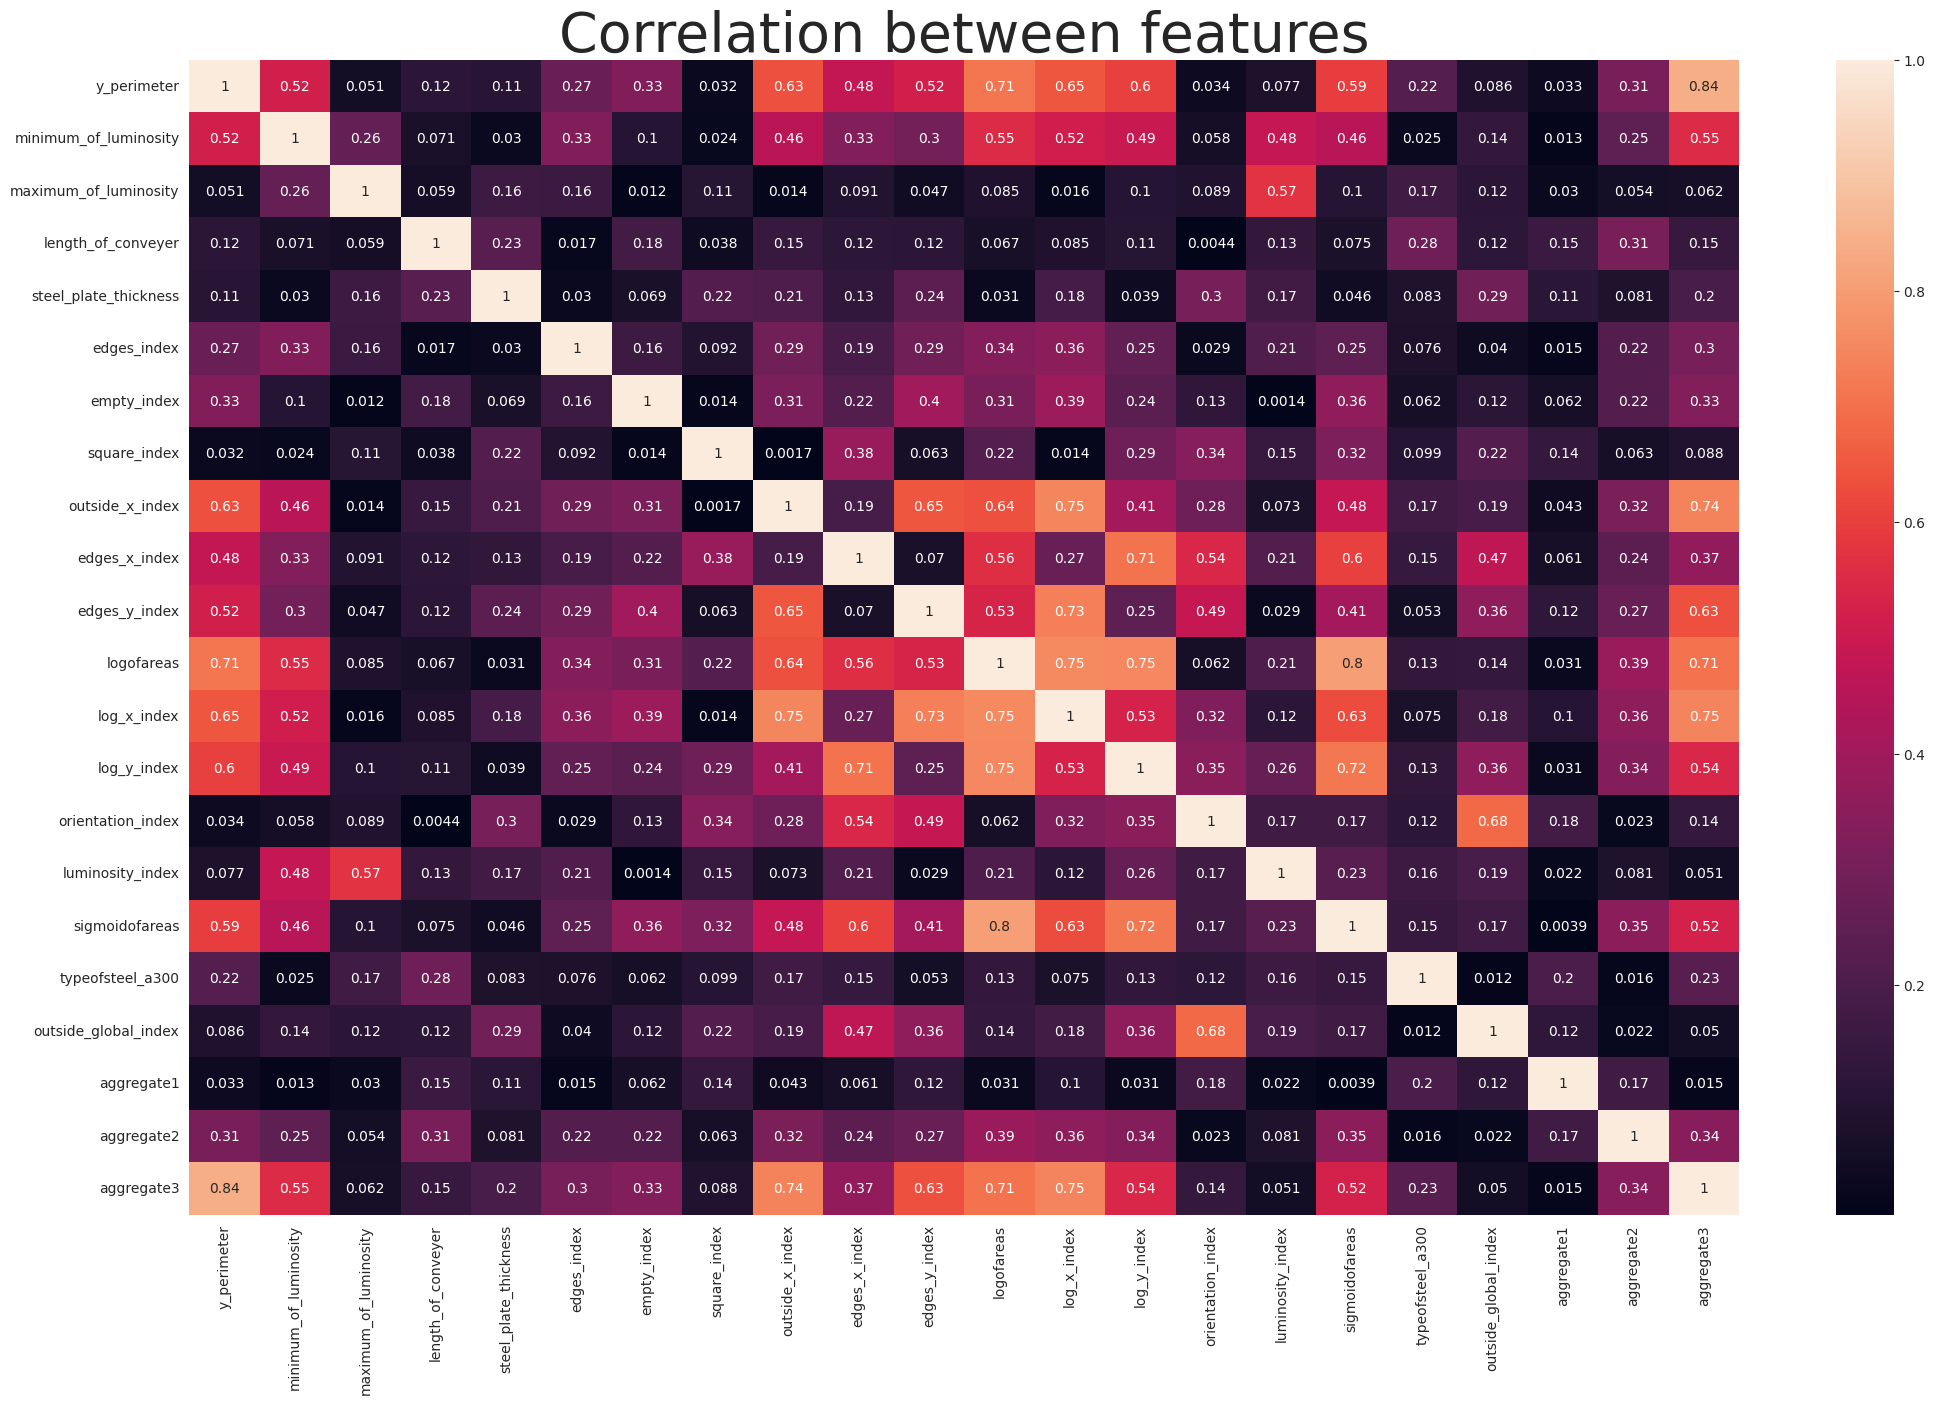

In [115]:
corr = df_norm.drop('anomaly', axis=1).corr().abs()

plt.figure(figsize = (25, 15))
plt.title('Correlation between features', fontsize = 40)
sns.heatmap(corr, annot = True)#, cbar = False)
#plt.savefig('correlation_matrix_2.png', dpi=300)
plt.show()

# Outlier detection

From the boxplots we can clearly see that the dataset seems to present some outliers. Check if these samples need to be removed or not

In [116]:
df_iqr = df_norm.copy()#.drop(target_cols, axis = 1)
Q1 = df_iqr.quantile(0.25)
Q3 = df_iqr.quantile(0.75)
IQR = Q3 - Q1

In [117]:
# first check how
anomaly_count = pd.DataFrame(df_norm['anomaly'].value_counts()).sort_index()
anomaly_count.index = target_cols

df_iqr = df_iqr[~((df_iqr < (Q1 - 1.5 * IQR)) | (df_iqr > (Q3 + 1.5 * IQR))).any(axis = 1)]
anomaly_count_iqr = pd.DataFrame(df_iqr['anomaly'].value_counts()).sort_index()
anomaly_count_iqr.index = target_cols

print('How many samples do we have left for each class?')
display(anomaly_count_iqr)
print('\n')

print('How many samples did we remove for each class?')
display(anomaly_count - anomaly_count_iqr)
print('\n')

lost_samples = round((len(df_norm) - len(df_iqr)) / len(df_norm), 2) * 100
print(f"The dataset lost {lost_samples}% of it's samples")
#del df_iqr, anomaly_count_iqr

How many samples do we have left for each class?


count
pastry         1332
z_scratch      1432
k_scatch         60
stains         1997
dirtiness      1481
bumps          1648
other_faults    878



How many samples did we remove for each class?


count
pastry          668
z_scratch       568
k_scatch       1940
stains            3
dirtiness       519
bumps           352
other_faults   1122



The dataset lost 37.0% of it's samples


We can see that some anomalies are greatly affected by the IQR outlier deletion. Specifically, k_scratch which was one of the most represented in the initial dataset, lost 640 samples remaining with only 33. Since we loose a lot of representation, and also because such extreme values of the features specifically for k_scratch might not be casual and our models could theoretically learn this relation, choose to use the datasets without IQR applied. Also, 32% of the dataset would be lost if we applied this outlier detection.

# Visualizing the classes

Perform a dimensionality reduction so that we can visualize the classes in a 3 dimensional space.

First try with PCA

In [118]:
X = df_norm.drop('anomaly', axis=1)

In [119]:
pca = PCA(n_components = 3)  
df_PCA = pca.fit_transform(X)
df_PCA = pd.DataFrame(df_PCA, columns = ['PC1', 'PC2', 'PC3'])
df_PCA['anomaly'] = df_norm['anomaly']

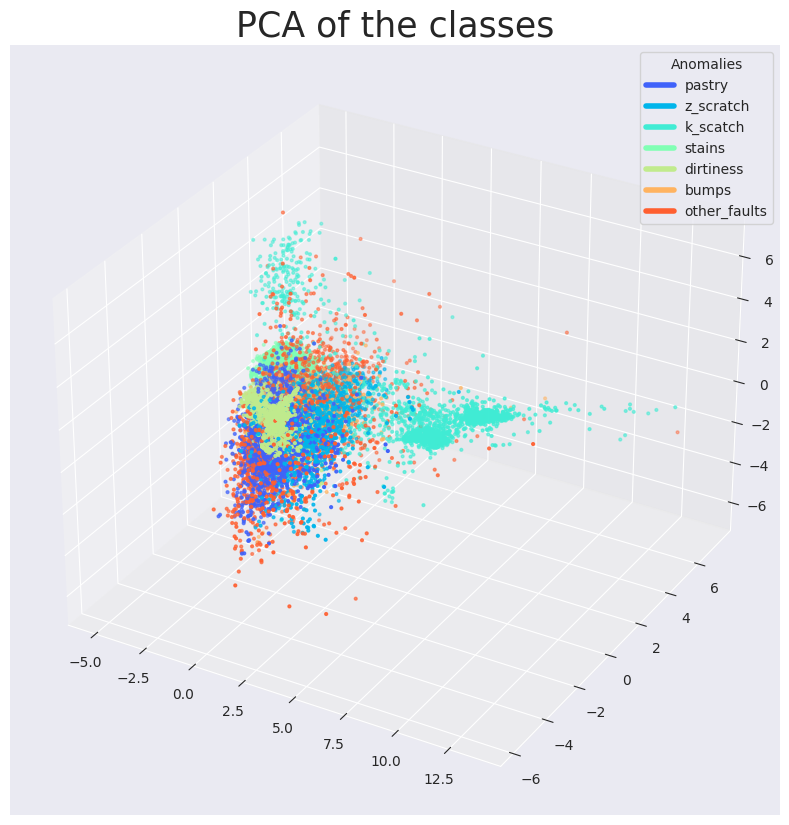

In [120]:
#%matplotlib qt
# uncomment the previous line of code if you want to display interactive plot

fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection='3d')
ax.set_title('PCA of the classes', fontsize = 25)
cmap = ListedColormap(palette_hist.as_hex())

ax.scatter(xs = df_PCA['PC1'], ys = df_PCA['PC2'], zs = df_PCA['PC3'], c = df_PCA['anomaly'], s = 4, cmap = cmap)

plt.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "best")

plt.show()

Seems like PCA doesn't do a great job with this datasets when it comes to visualizing clusters of the classes, perhaps because of the non-linearity of the correlations between the features. 

t-SNE

In [41]:
tsne = TSNE(n_components = 3, random_state = 2)

df_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(df_tsne, columns = ['PC1', 'PC2', 'PC3'])
df_tsne['anomaly'] = df_norm['anomaly']

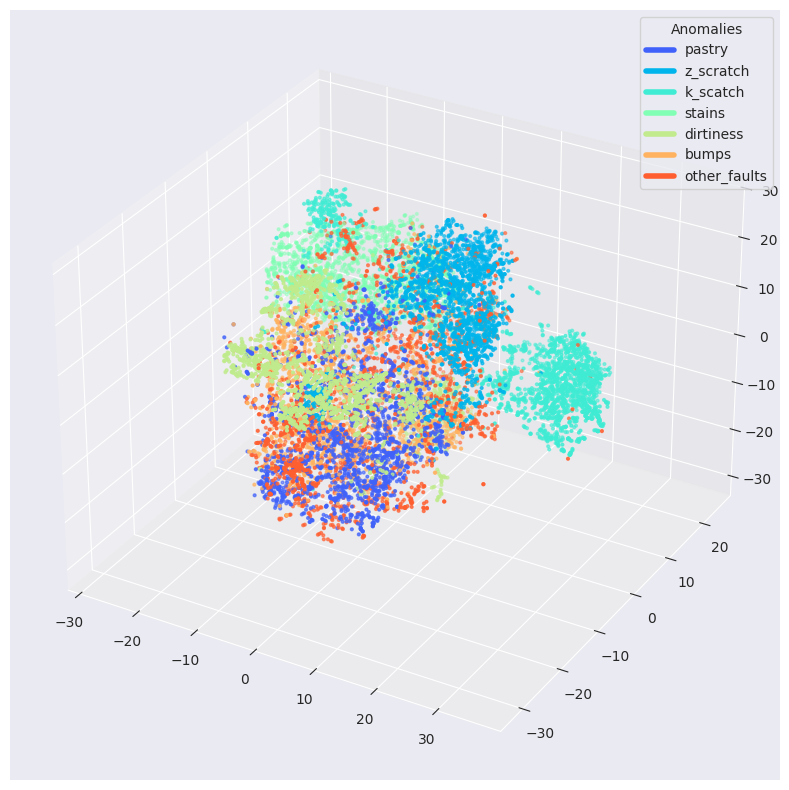

In [42]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection = '3d')

ax.scatter(df_tsne['PC1'], df_tsne['PC2'], df_tsne['PC3'], c = df_tsne['anomaly'], s = 4, cmap = cmap)

plt.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "best")

plt.show()

UMAP

In [121]:
ump = umap.UMAP(n_components=3, random_state=10, n_neighbors=200, min_dist=0.5, metric='canberra')

df_umap = ump.fit_transform(X)
df_umap = pd.DataFrame(df_umap, columns = ['PC1', 'PC2', 'PC3'])
df_umap['anomaly'] = df_norm['anomaly']


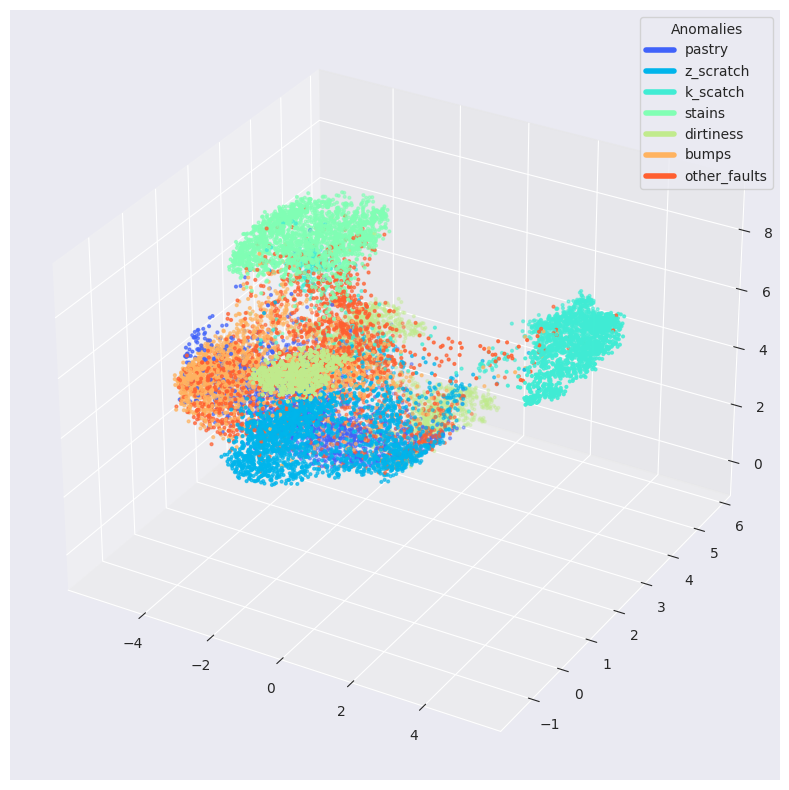

In [122]:
fig = plt.figure(figsize = (15, 10))
ax = fig.add_subplot(projection = '3d')

ax.scatter(df_umap['PC1'], df_umap['PC2'], df_umap['PC3'], c = df_umap['anomaly'], s = 4, cmap = cmap)

plt.legend(handles, [str(u) for u in target_cols], title = "Anomalies", loc = "best")

plt.show()

UMAP and t-SNE do a better job then PCA when it comes to dimensionality reduction while preserving the clusterization of the different classes. This implies non-linearity in the correlation between the features, and that it might be better to use the UMAP/t-SNE dimensionality reducted dataframes insteand of the original one or the PCA one.

# Models

In [45]:
metrics_df = pd.DataFrame([], columns = ['Accuracy', 'Precision', 'Recall', 'F1 Score'])
time_df = pd.DataFrame([], columns = ['Avg. Time'])
display(metrics_df)
display(time_df.T)

Empty DataFrame
Columns: [Accuracy, Precision, Recall, F1 Score]
Index: []

Empty DataFrame
Columns: []
Index: [Avg. Time]

## Naive Bayes

### Without preprocessing

In [46]:
X_full = df.drop('anomaly', axis = 1)
y_full = df['anomaly']

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for fold 1: 40.46%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for fold 2: 48.97%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for fold 3: 44.85%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for fold 4: 48.71%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for fold 5: 48.2%
--------------------------------------------------------

Confusion matrix and classification report for fold 5 ...
              precision    recall  f1-score   support

           0       0.12      0.03      0.05        32
           1       0.33      0.83      0.48        29
           2       0.87      0.78      0.82        76
           3 

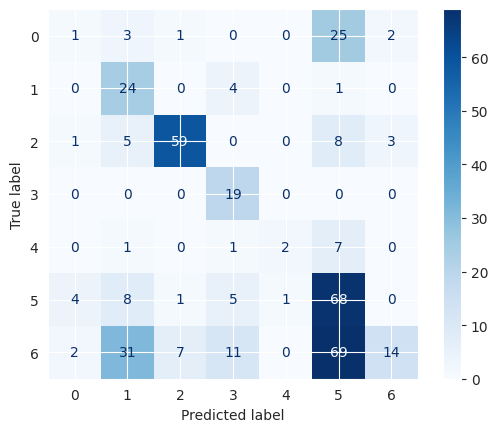

Average time per fold: 0.01 seconds


In [47]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True, random_state = 2)

acc_per_fold, precision_per_fold, recall_per_fold, f1_per_fold, time_per_fold = [], [], [], [], []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X_full, y_full):
    y_t = np.array(y_full.iloc[test])

    start_time = time.time()

    gnb = GaussianNB()

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    gnb.fit(X_full.iloc[train], y_full.iloc[train])
    y_pred = gnb.predict(X_full.iloc[test])

    end_time = time.time()
    duration = end_time - start_time
    time_per_fold.append(duration)

    accuracy, precision, recall, f1 = metrics_of_prediction(y_t, y_pred, fold_no)

    acc_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    if fold_no == num_splits:
        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} ...')
        plot_cm(y_t, y_pred)

        metrics_df.loc['Gnb Raw'] = [f'{rounded_mean(acc_per_fold)}%',
                                 f'{rounded_mean(precision_per_fold)}%',
                                 f'{rounded_mean(recall_per_fold)}%',
                                 f'{rounded_mean(f1_per_fold)}%']


    fold_no += 1


average_time_per_fold = sum(time_per_fold) / len(time_per_fold)
time_df.loc['Gnb Raw'] = round(average_time_per_fold, 2)
print(f'Average time per fold: {average_time_per_fold:.2f} seconds')

In [48]:
display(metrics_df)
display(time_df.T)

Accuracy Precision  Recall F1 Score
Gnb Raw   46.24%    45.62%  51.58%   40.01%

Gnb Raw
Avg. Time     0.01

### With preprocessing

In [49]:
df_norm = df_norm.sample(frac = 1, random_state=2)
X = df_norm.drop('anomaly', axis = 1)
y = df_norm['anomaly']

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for fold 1: 79.61%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for fold 2: 79.14%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for fold 3: 80.39%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for fold 4: 78.64%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for fold 5: 79.54%
--------------------------------------------------------

Confusion matrix and classification report for fold 5 ...
              precision    recall  f1-score   support

           0       0.61      0.84      0.71       393
           1       0.91      0.90      0.90       411
           2       0.98      0.84      0.90       394
           3

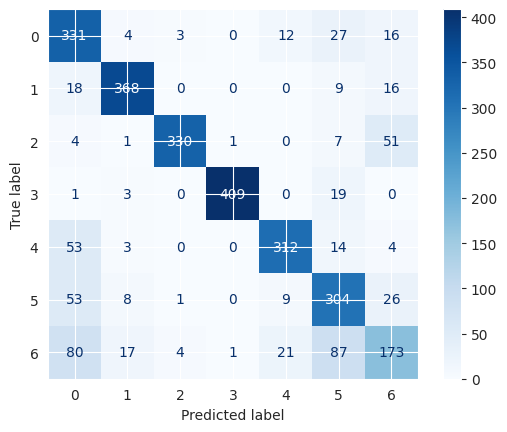

Average time per fold: 0.01 seconds


In [50]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True, random_state = 2)

acc_per_fold, precision_per_fold, recall_per_fold, f1_per_fold, time_per_fold = [], [], [], [], []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X, y):
    y_t = np.array(y.iloc[test])
    start_time = time.time()

    gnb = GaussianNB()

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    gnb.fit(X.iloc[train], y.iloc[train])
    y_pred = gnb.predict(X.iloc[test])

    end_time = time.time()
    duration = end_time - start_time
    time_per_fold.append(duration)

    accuracy, precision, recall, f1 = metrics_of_prediction(y_t, y_pred, fold_no)

    acc_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    if fold_no == num_splits:
        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} ...')
        plot_cm(y_t, y_pred)

        metrics_df.loc['Gnb'] = [f'{rounded_mean(acc_per_fold)}%',
                                 f'{rounded_mean(precision_per_fold)}%',
                                 f'{rounded_mean(recall_per_fold)}%',
                                 f'{rounded_mean(f1_per_fold)}%']


    fold_no += 1

average_time_per_fold = sum(time_per_fold) / len(time_per_fold)
time_df.loc['Gnb'] = round(average_time_per_fold, 2)
print(f'Average time per fold: {average_time_per_fold:.2f} seconds')

In [51]:
display(metrics_df)
display(time_df.T)

Accuracy Precision  Recall F1 Score
Gnb Raw   46.24%    45.62%  51.58%   40.01%
Gnb       79.46%    80.42%  79.45%   79.37%

Gnb Raw   Gnb
Avg. Time     0.01  0.01

As we've seen in the TSNE visualization of the classes, class 5 and 6 are difficultly differentiable. This is confirmed by the the latter confusion matrix. We might try using some hyperparameter tuning/priors/loss balanced learning in the case of the naive bayes classifier

## Support Vector Classifier

### Without parameter hypertuning

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for fold 1: 91.89%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for fold 2: 92.0%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for fold 3: 92.79%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for fold 4: 91.04%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for fold 5: 92.07%
--------------------------------------------------------

Confusion matrix and classification report for fold 5 ...
              precision    recall  f1-score   support

           0       0.85      0.90      0.88       393
           1       0.96      0.95      0.95       411
           2       0.99      0.95      0.97       394
           3 

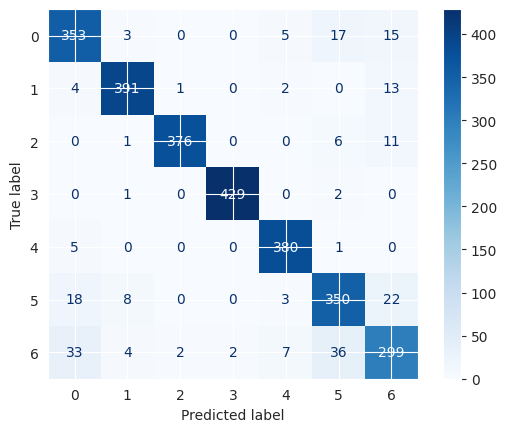

Average time per fold: 1.74 seconds


In [52]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True, random_state = 2)

acc_per_fold, precision_per_fold, recall_per_fold, f1_per_fold, time_per_fold = [], [], [], [], []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X, y):
    start_time = time.time()
    svm = SVC()

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    svm.fit(X.iloc[train], y.iloc[train])
    y_t = y.iloc[test]
    y_pred = svm.predict(X.iloc[test])

    end_time = time.time()
    duration = end_time - start_time
    time_per_fold.append(duration)

    accuracy, precision, recall, f1 = metrics_of_prediction(y_t, y_pred, fold_no)

    acc_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    if fold_no == num_splits:
        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} ...')
        plot_cm(y_t, y_pred)

        metrics_df.loc['SVM'] = [f'{rounded_mean(acc_per_fold)}%',
                                 f'{rounded_mean(precision_per_fold)}%',
                                 f'{rounded_mean(recall_per_fold)}%',
                                 f'{rounded_mean(f1_per_fold)}%']
    fold_no += 1

average_time_per_fold = sum(time_per_fold) / len(time_per_fold)
time_df.loc['SVM'] = round(average_time_per_fold, 2)
print(f'Average time per fold: {average_time_per_fold:.2f} seconds')

In [53]:
display(metrics_df)
display(time_df.T)

Accuracy Precision  Recall F1 Score
Gnb Raw   46.24%    45.62%  51.58%   40.01%
Gnb       79.46%    80.42%  79.45%   79.37%
SVM       91.96%    91.96%  91.95%   91.89%

Gnb Raw   Gnb   SVM
Avg. Time     0.01  0.01  1.74

### Hyperparameter tuning for SVM

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for fold 1: 92.61%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for fold 2: 92.54%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for fold 3: 93.14%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for fold 4: 91.61%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for fold 5: 92.82%
--------------------------------------------------------

Confusion matrix and classification report for fold 5 ...
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       393
           1       0.96      0.95      0.96       411
           2       0.99      0.97      0.98       394
           3

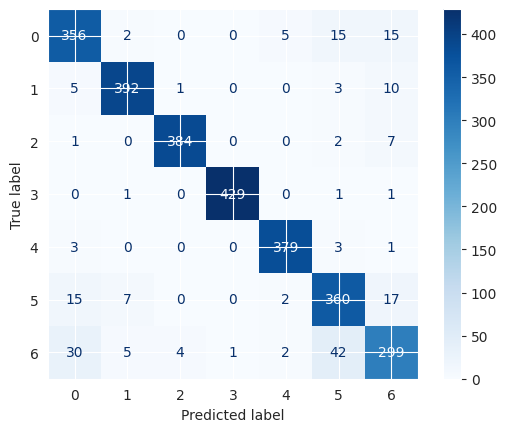

Average time per fold: 384.30 seconds


In [54]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True, random_state = 2)

acc_per_fold, precision_per_fold, recall_per_fold, f1_per_fold, time_per_fold = [], [], [], [], []

parameters = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X, y):
    start_time = time.time()
    svc = SVC()
    clf = GridSearchCV(svc, parameters, scoring = 'accuracy', refit = True, verbose = 0)

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    clf.fit(X.iloc[train], y.iloc[train])

    y_t = y.iloc[test]
    y_pred = clf.predict(X.iloc[test])

    end_time = time.time()
    duration = end_time - start_time
    time_per_fold.append(duration)

    accuracy, precision, recall, f1 = metrics_of_prediction(y_t, y_pred, fold_no)

    acc_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    if fold_no == num_splits:
        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} ...')
        plot_cm(y_t, y_pred)

        metrics_df.loc['SVM Grid'] = [f'{rounded_mean(acc_per_fold)}%',
                                      f'{rounded_mean(precision_per_fold)}%',
                                      f'{rounded_mean(recall_per_fold)}%',
                                      f'{rounded_mean(f1_per_fold)}%']
    fold_no += 1


average_time_per_fold = sum(time_per_fold) / len(time_per_fold)
time_df.loc['SVM Grid'] = round(average_time_per_fold, 2)
print(f'Average time per fold: {average_time_per_fold:.2f} seconds')

In [55]:
display(metrics_df)
display(time_df.T)

Accuracy Precision  Recall F1 Score
Gnb Raw    46.24%    45.62%  51.58%   40.01%
Gnb        79.46%    80.42%  79.45%   79.37%
SVM        91.96%    91.96%  91.95%   91.89%
SVM Grid   92.54%    92.54%  92.54%    92.5%

Gnb Raw   Gnb   SVM  SVM Grid
Avg. Time     0.01  0.01  1.74     384.3

## Neural Network Classifier

------------------------------------------------------------------------
Training for fold 1 ...


  0%|          | 0/20 [00:00<?, ?it/s]

2025-03-04 10:06:03.240338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-04 10:06:03.284385: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Best hyperparameters for fold 1: {'num_early_layers': 2, 'early_neurons_0': 112, 'dropout_0': 0.21968544537441564, 'early_neurons_1': 96, 'dropout_1': 0.22975003049500722, 'num_later_layers': 2, 'later_neurons_0': 48, 'later_neurons_1': 64, 'learning_rate': 0.006043763604426501, 'batch_size': 256}
Accuracy score for fold 1: 92.68%
------------------------------------------------------------------------
Training for fold 2 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Best hyperparameters for fold 2: {'num_early_layers': 2, 'early_neurons_0': 112, 'dropout_0': 0.16594643964533787, 'early_neurons_1': 120, 'dropout_1': 0.1604859497022928, 'num_later_layers': 2, 'later_neurons_0': 24, 'later_neurons_1': 48, 'learning_rate': 0.0023899336157669213, 'batch_size': 256}
Accuracy score for fold 2: 93.11%
------------------------------------------------------------------------
Training for fold 3 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Best hyperparameters for fold 3: {'num_early_layers': 2, 'early_neurons_0': 88, 'dropout_0': 0.12600659547704593, 'early_neurons_1': 64, 'dropout_1': 0.20413056783315614, 'num_later_layers': 2, 'later_neurons_0': 64, 'later_neurons_1': 40, 'learning_rate': 0.0008131705164354208, 'batch_size': 32}
Accuracy score for fold 3: 91.93%
------------------------------------------------------------------------
Training for fold 4 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Best hyperparameters for fold 4: {'num_early_layers': 2, 'early_neurons_0': 104, 'dropout_0': 0.1665736618904077, 'early_neurons_1': 128, 'dropout_1': 0.10468408873735602, 'num_later_layers': 2, 'later_neurons_0': 48, 'later_neurons_1': 40, 'learning_rate': 0.00408140033538909, 'batch_size': 128}
Accuracy score for fold 4: 91.46%
------------------------------------------------------------------------
Training for fold 5 ...


  0%|          | 0/20 [00:00<?, ?it/s]

Best hyperparameters for fold 5: {'num_early_layers': 3, 'early_neurons_0': 120, 'dropout_0': 0.15089296589630066, 'early_neurons_1': 96, 'dropout_1': 0.10669765358673904, 'early_neurons_2': 72, 'dropout_2': 0.10915645582124185, 'num_later_layers': 3, 'later_neurons_0': 24, 'later_neurons_1': 8, 'later_neurons_2': 24, 'learning_rate': 0.0003198848494628102, 'batch_size': 32}
Accuracy score for fold 5: 92.86%
--------------------------------------------------------

Confusion matrix and classification report for fold 5 ...
              precision    recall  f1-score   support

           0       0.85      0.93      0.89       393
           1       0.97      0.95      0.96       411
           2       0.98      0.98      0.98       394
           3       0.99      0.99      0.99       432
           4       0.97      0.98      0.98       386
           5       0.86      0.89      0.87       401
           6       0.87      0.77      0.82       383

    accuracy                          

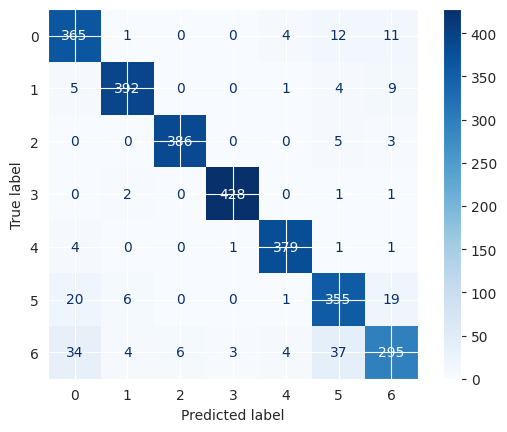

Average time per fold: 626.18 seconds


In [56]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True, random_state = 2)

acc_per_fold, precision_per_fold, recall_per_fold, f1_per_fold, time_per_fold = [], [], [], [], []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X, y):
    # Define the model architecture
    X_train, X_t = X.iloc[train], X.iloc[test]
    y_train, y_t = y.iloc[train], y.iloc[test]

    # Optuna Study for Hyperparameter Tuning
    optuna.logging.set_verbosity(optuna.logging.WARNING)
    study = optuna.create_study(direction = "maximize", pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    start_time = time.time()

    study.optimize(lambda trial: nn_optimization.objective(trial, X_train, y_train, X_t, y_t), n_trials = 20, show_progress_bar=True)

    # Train best model on the full training set of the fold
    best_params = study.best_params
    print(f"Best hyperparameters for fold {fold_no}: {best_params}")

    best_model = nn_optimization.create_model(optuna.trial.FixedTrial(best_params), X_train.shape[1])
    best_model.fit(X_train, y_train, batch_size=best_params["batch_size"], epochs=100, verbose=0)

    y_pred = np.argmax(best_model.predict(X_t, verbose=0), axis = 1)

    end_time = time.time()
    duration = end_time - start_time
    time_per_fold.append(duration)

    accuracy, precision, recall, f1 = metrics_of_prediction(y_t, y_pred, fold_no)

    acc_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    if fold_no == num_splits:
        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} ...')
        plot_cm(y_t, y_pred)

        metrics_df.loc['FF Neural Network'] = [f'{rounded_mean(acc_per_fold)}%',
                                               f'{rounded_mean(precision_per_fold)}%',
                                               f'{rounded_mean(recall_per_fold)}%',
                                               f'{rounded_mean(f1_per_fold)}%']
    fold_no = fold_no + 1

average_time_per_fold = sum(time_per_fold) / len(time_per_fold)
time_df.loc['FF Neural Network'] = round(average_time_per_fold, 2)
print(f'Average time per fold: {average_time_per_fold:.2f} seconds')

In [57]:
display(metrics_df)
display(time_df.T)

Accuracy Precision  Recall F1 Score
Gnb Raw             46.24%    45.62%  51.58%   40.01%
Gnb                 79.46%    80.42%  79.45%   79.37%
SVM                 91.96%    91.96%  91.95%   91.89%
SVM Grid            92.54%    92.54%  92.54%    92.5%
FF Neural Network   92.41%    92.47%  92.43%   92.33%

Gnb Raw   Gnb   SVM  SVM Grid  FF Neural Network
Avg. Time     0.01  0.01  1.74     384.3             626.18

## Autoencoder classifier

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for fold 1: 86.14%
Accuracy score for fold 1: 92.11%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for fold 2: 86.0%
Accuracy score for fold 2: 91.96%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for fold 3: 87.25%
Accuracy score for fold 3: 92.43%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for fold 4: 84.36%
Accuracy score for fold 4: 92.43%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for fold 5: 83.36%
Accuracy score for fold 5: 92.14%
--------------------------------------------------------

Confusion matrix and classification report for fold 5 Neural network ...
              precision    recall  f1-score  

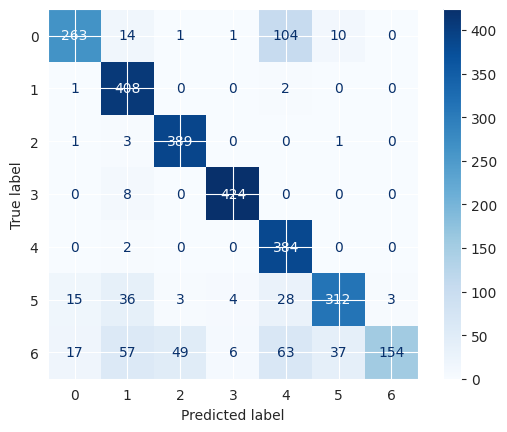

--------------------------------------------------------

Confusion matrix and classification report for fold 5 SVC ...
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       393
           1       0.96      0.95      0.95       411
           2       0.98      0.98      0.98       394
           3       1.00      0.99      1.00       432
           4       0.97      0.98      0.98       386
           5       0.84      0.84      0.84       401
           6       0.80      0.80      0.80       383

    accuracy                           0.92      2800
   macro avg       0.92      0.92      0.92      2800
weighted avg       0.92      0.92      0.92      2800



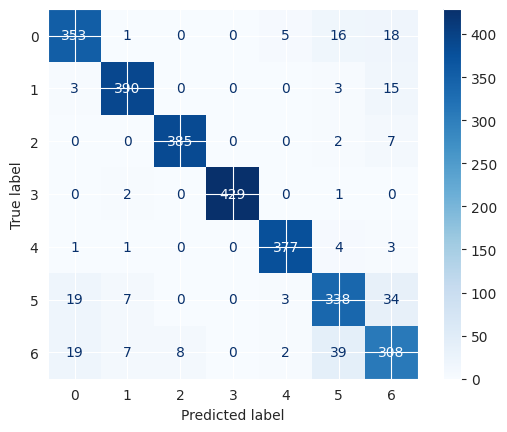

Average time per fold: 78.06 seconds
Average time per fold: 294.84 seconds


In [58]:
# Define the K-fold Cross Validator
num_splits = 5
k_fold = KFold(n_splits = num_splits, shuffle = True, random_state = 2)

sc = StandardScaler()

param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

acc_per_fold_nn, precision_per_fold_nn, recall_per_fold_nn, f1_per_fold_nn, time_per_fold_nn = [], [], [], [], []
acc_per_fold_svm, precision_per_fold_svm, recall_per_fold_svm, f1_per_fold_svm, time_per_fold_svm = [], [], [], [], []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X, y):
    # Input layer
    input_layer = Input(shape=(X.shape[1],))

    # Encoder: transformation towards latent space
    encoded = Dense(512, activation='relu')(input_layer)
    encoded = Dense(256, activation='relu')(encoded)
    encoded = Dense(128, activation='relu')(encoded)
    encoded = Dense(64, activation='relu')(encoded)
    x = Dense(15, activation='relu')(encoded)

    # Decoder: data reconstruction
    encoded = Dense(64, activation='relu')(x)
    encoded = Dense(128, activation='relu')(encoded)
    decoded = Dense(256, activation='relu')(encoded)
    decoded = Dense(512, activation='relu')(decoded)
    output_reconstruction = Dense(X.shape[1], activation = 'relu', name = "reconstruction")(decoded)

    # Classifier: class prediction
    output_classification = Dense(7, activation = 'softmax', name = "classification")(x)

    # Define the autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=[output_reconstruction, output_classification])
    classification = Model(inputs = x, outputs = output_classification)

    # Compile the model with a combined loss
    autoencoder.compile(
                        optimizer = 'adam',
                        loss = {
                            "reconstruction": "mse",
                            "classification": 'sparse_categorical_crossentropy'
                        },
                        loss_weights={"reconstruction": 0.5, "classification": 0.5},
                        metrics = ['mse', 'accuracy']
                        )
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    start_time_aa = time.time()

    # Fit data to model
    history = autoencoder.fit(
    X.iloc[train], [X.iloc[train], y.iloc[train]],  # Input: X, Outputs: [reconstruction, classification]
    batch_size = 256,
    epochs = 100,
    shuffle = True,
    validation_split = 0.2,
    verbose = 0
    )

    # Define encoder model to extract latent features
    encoder = Model(inputs = autoencoder.input, outputs = x)

    # Generate latent representations
    latent_features = encoder.predict(X.iloc[train], verbose = 0)
    latent_features_test = encoder.predict(X.iloc[test], verbose = 0)
    latent_features = sc.fit_transform(latent_features)
    latent_features_test = sc.fit_transform(latent_features_test)

    end_time_aa = time.time()
    duration = end_time_aa - start_time_aa
    time_per_fold_nn.append(duration)

    y_t = y.iloc[test]
    y_pred_nn = classification.predict(latent_features_test, verbose = 0)
    y_pred_nn = np.argmax(y_pred_nn, axis = 1)

    accuracy_nn, precision_nn, recall_nn, f1_nn = metrics_of_prediction(y_t, y_pred_nn, fold_no)

    acc_per_fold_nn.append(accuracy_nn)
    precision_per_fold_nn.append(precision_nn)
    recall_per_fold_nn.append(recall_nn)
    f1_per_fold_nn.append(f1_nn)

    svm_classifier = SVC()
    start_time_svm = time.time()
    grid = GridSearchCV(svm_classifier, param_grid, scoring = 'accuracy', refit = True, verbose = 0)
    grid.fit(latent_features, y.iloc[train])
    y_pred_svm = grid.predict(latent_features_test)

    end_time_svm = time.time()
    duration = end_time_svm - start_time_aa
    time_per_fold_svm.append(duration)

    accuracy_svm, precision_svm, recall_svm, f1_svm = metrics_of_prediction(y_t, y_pred_svm, fold_no)

    acc_per_fold_svm.append(accuracy_svm)
    precision_per_fold_svm.append(precision_svm)
    recall_per_fold_svm.append(recall_svm)
    f1_per_fold_svm.append(f1_svm)

    if fold_no == num_splits:
        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} Neural network ...')
        plot_cm(y_t, y_pred_nn)

        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} SVC ...')
        plot_cm(y_t, y_pred_svm)

        metrics_df.loc['AutoEncoder NN Classifier'] = [f'{rounded_mean(acc_per_fold_nn)}%',
                                                       f'{rounded_mean(precision_per_fold_nn)}%',
                                                       f'{rounded_mean(recall_per_fold_nn)}%',
                                                       f'{rounded_mean(f1_per_fold_nn)}%']

        metrics_df.loc['AutoEncoder SVM Classifier'] = [f'{rounded_mean(acc_per_fold_svm)}%',
                                                        f'{rounded_mean(precision_per_fold_svm)}%',
                                                        f'{rounded_mean(recall_per_fold_svm)}%',
                                                        f'{rounded_mean(f1_per_fold_svm)}%']

    fold_no = fold_no + 1


average_time_per_fold_nn = sum(time_per_fold_nn) / len(time_per_fold_nn)
time_df.loc['AutoEncoder NN Classifier'] = round(average_time_per_fold_nn, 2)
print(f'Average time per fold: {average_time_per_fold_nn:.2f} seconds')


average_time_per_fold_svm = sum(time_per_fold_svm) / len(time_per_fold_svm)
time_df.loc['AutoEncoder SVM Classifier'] = round(average_time_per_fold_svm, 2)
print(f'Average time per fold: {average_time_per_fold_svm:.2f} seconds')


In [59]:
display(metrics_df)
display(time_df.T)

Accuracy Precision  Recall F1 Score
Gnb Raw                      46.24%    45.62%  51.58%   40.01%
Gnb                          79.46%    80.42%  79.45%   79.37%
SVM                          91.96%    91.96%  91.95%   91.89%
SVM Grid                     92.54%    92.54%  92.54%    92.5%
FF Neural Network            92.41%    92.47%  92.43%   92.33%
AutoEncoder NN Classifier    85.42%     87.0%  85.41%   84.26%
AutoEncoder SVM Classifier   92.21%    92.16%  92.22%   92.17%

Gnb Raw   Gnb   SVM  SVM Grid  FF Neural Network  \
Avg. Time     0.01  0.01  1.74     384.3             626.18   

           AutoEncoder NN Classifier  AutoEncoder SVM Classifier  
Avg. Time                      78.06                      294.84

## TabNet

"TabNet: Attentive Interpretable Tabular Learning" paper: https://arxiv.org/abs/1908.07442

------------------------------------------------------------------------
Training for fold 1 ...
Accuracy score for fold 1: 91.96%
------------------------------------------------------------------------
Training for fold 2 ...
Accuracy score for fold 2: 91.57%
------------------------------------------------------------------------
Training for fold 3 ...
Accuracy score for fold 3: 91.75%
------------------------------------------------------------------------
Training for fold 4 ...
Accuracy score for fold 4: 90.93%
------------------------------------------------------------------------
Training for fold 5 ...
Accuracy score for fold 5: 91.86%
--------------------------------------------------------

Confusion matrix and classification report for fold 5 ...
              precision    recall  f1-score   support

           0       0.86      0.91      0.89       399
           1       0.97      0.96      0.96       367
           2       0.98      0.97      0.97       429
           3

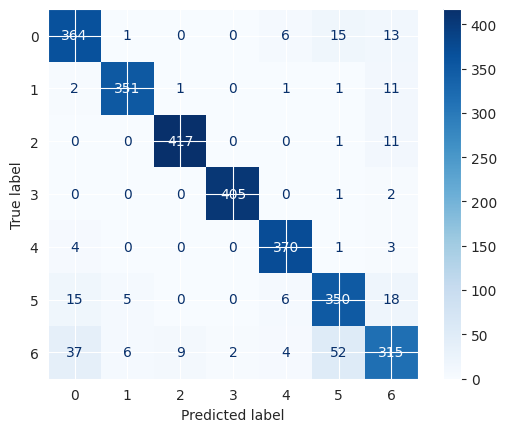

Average time per fold: 230.63 seconds


In [60]:
num_splits = 5
k_fold = KFold(n_splits = num_splits)

acc_per_fold, precision_per_fold, recall_per_fold, f1_per_fold, time_per_fold = [], [], [], [], []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X, y):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    start_time=time.time()

    model = TabNetClassifier()
    # Suppress TabNet's print output
    with contextlib.redirect_stdout(io.StringIO()):
        model.fit(
                np.array(X.iloc[train]), np.array(y.iloc[train]),
                max_epochs=200,
                eval_set=[(np.array(X.iloc[test]), np.array(y.iloc[test]))],
                patience=30,
                batch_size=256
            )
    y_t = y.iloc[test]
    y_pred = model.predict(np.array(X.iloc[test]))

    end_time = time.time()  # End timing
    duration = end_time - start_time  # Compute time taken
    time_per_fold.append(duration)

    accuracy, precision, recall, f1 = metrics_of_prediction(y_t, y_pred, fold_no)

    acc_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    if fold_no == num_splits:
        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} ...')
        plot_cm(y_t, y_pred)

        metrics_df.loc['TabNet'] = [f'{rounded_mean(acc_per_fold)}%',
                                    f'{rounded_mean(precision_per_fold)}%',
                                    f'{rounded_mean(recall_per_fold)}%',
                                    f'{rounded_mean(f1_per_fold)}%']
    fold_no = fold_no + 1


average_time_per_fold = sum(time_per_fold) / len(time_per_fold)
time_df.loc['TabNet'] = round(average_time_per_fold, 2)
print(f'Average time per fold: {average_time_per_fold:.2f} seconds')

In [61]:
display(metrics_df)
display(time_df.T)

Accuracy Precision  Recall F1 Score
Gnb Raw                      46.24%    45.62%  51.58%   40.01%
Gnb                          79.46%    80.42%  79.45%   79.37%
SVM                          91.96%    91.96%  91.95%   91.89%
SVM Grid                     92.54%    92.54%  92.54%    92.5%
FF Neural Network            92.41%    92.47%  92.43%   92.33%
AutoEncoder NN Classifier    85.42%     87.0%  85.41%   84.26%
AutoEncoder SVM Classifier   92.21%    92.16%  92.22%   92.17%
TabNet                       91.61%    91.58%  91.61%   91.55%

Gnb Raw   Gnb   SVM  SVM Grid  FF Neural Network  \
Avg. Time     0.01  0.01  1.74     384.3             626.18   

           AutoEncoder NN Classifier  AutoEncoder SVM Classifier  TabNet  
Avg. Time                      78.06                      294.84  230.63

## FTTransformer

"Revisiting Deep Learning Models for Tabular Data" paper: https://arxiv.org/abs/2106.11959

![Alt Text](https://www.researchgate.net/publication/372985818/figure/fig1/AS:11431281180233791@1691514218219/The-FT-Transformer-architecture-the-proposed-architecture-contains-two-major-blocks.png)

------------------------------------------------------------------------
Training for fold 1 ...


100%|██████████| 50/50 [02:16<00:00,  2.72s/it]


Accuracy score for fold 1: 92.63%
------------------------------------------------------------------------
Training for fold 2 ...


100%|██████████| 50/50 [02:17<00:00,  2.75s/it]


Accuracy score for fold 2: 93.57%
------------------------------------------------------------------------
Training for fold 3 ...


100%|██████████| 50/50 [02:17<00:00,  2.75s/it]


Accuracy score for fold 3: 92.68%
------------------------------------------------------------------------
Training for fold 4 ...


100%|██████████| 50/50 [02:18<00:00,  2.77s/it]


Accuracy score for fold 4: 93.57%
------------------------------------------------------------------------
Training for fold 5 ...


100%|██████████| 50/50 [02:18<00:00,  2.78s/it]


Accuracy score for fold 5: 93.35%
--------------------------------------------------------

Confusion matrix and classification report for fold 5 ...
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       318
           1       0.95      0.99      0.97       316
           2       0.98      0.99      0.99       320
           3       0.99      1.00      1.00       322
           4       1.00      0.98      0.99       324
           5       0.87      0.90      0.88       314
           6       0.86      0.78      0.82       326

    accuracy                           0.93      2240
   macro avg       0.93      0.93      0.93      2240
weighted avg       0.93      0.93      0.93      2240



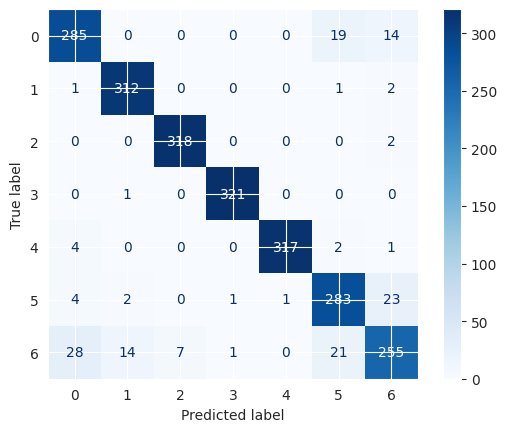

-----------------------------------
Average time per fold: 138.25 seconds


In [62]:
num_splits = 5
k_fold = KFold(n_splits=num_splits, shuffle=True)

acc_per_fold, precision_per_fold, recall_per_fold, f1_per_fold, time_per_fold = [], [], [], [], []

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in k_fold.split(X, y):
    df_temp = pd.concat([X.iloc[train], y.iloc[train]], ignore_index=True, axis = 1)
    df_temp.columns = df_norm.columns
    df_temp.dropna(inplace = True)

    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    device = fttransformer.create_device()
    start_time = time.time()

    X_num_train, X_num_test, X_cat_train, X_cat_test, y_tr, y_t = fttransformer.create_tensors(df_temp, 'anomaly', ['typeofsteel_a300', 'outside_global_index'], device)

    train_loader = fttransformer.create_dataloader(256, X_num_train, X_cat_train, y_tr)
    cardinalities = fttransformer.get_cardinalities(X_cat_train)

    model, optimizer, loss_fn = fttransformer.compile_transformer(X_num_train.shape[1], cardinalities, 7, device)
    model = fttransformer.train_transformer(model, optimizer, loss_fn, epochs=50, train_loader=train_loader, device=device)

    y_pred = np.array(fttransformer.get_prediction(model, X_num_test, X_cat_test).cpu())
    y_t = np.array(y_t.cpu())

    end_time = time.time()
    duration = end_time - start_time
    time_per_fold.append(duration)

    accuracy, precision, recall, f1 = metrics_of_prediction(y_t, y_pred, fold_no)
    acc_per_fold.append(accuracy)
    precision_per_fold.append(precision)
    recall_per_fold.append(recall)
    f1_per_fold.append(f1)

    if fold_no == num_splits:
        print('--------------------------------------------------------\n')
        print(f'Confusion matrix and classification report for fold {fold_no} ...')
        plot_cm(y_t, y_pred)

        print('-----------------------------------')
        metrics_df.loc['FTTransformer'] = [f'{rounded_mean(acc_per_fold)}%',
                                           f'{rounded_mean(precision_per_fold)}%',
                                           f'{rounded_mean(recall_per_fold)}%',
                                           f'{rounded_mean(f1_per_fold)}%']
    fold_no = fold_no + 1


average_time_per_fold = sum(time_per_fold) / len(time_per_fold)
time_df.loc['FTTransformer'] = round(average_time_per_fold, 2)
print(f'Average time per fold: {average_time_per_fold:.2f} seconds')

# Results

In [63]:
display(metrics_df)
display(time_df.T)

Accuracy Precision  Recall F1 Score
Gnb Raw                      46.24%    45.62%  51.58%   40.01%
Gnb                          79.46%    80.42%  79.45%   79.37%
SVM                          91.96%    91.96%  91.95%   91.89%
SVM Grid                     92.54%    92.54%  92.54%    92.5%
FF Neural Network            92.41%    92.47%  92.43%   92.33%
AutoEncoder NN Classifier    85.42%     87.0%  85.41%   84.26%
AutoEncoder SVM Classifier   92.21%    92.16%  92.22%   92.17%
TabNet                       91.61%    91.58%  91.61%   91.55%
FTTransformer                93.16%    93.08%  93.16%   93.07%

Gnb Raw   Gnb   SVM  SVM Grid  FF Neural Network  \
Avg. Time     0.01  0.01  1.74     384.3             626.18   

           AutoEncoder NN Classifier  AutoEncoder SVM Classifier  TabNet  \
Avg. Time                      78.06                      294.84  230.63   

           FTTransformer  
Avg. Time     138.252131

In [14]:
metrics_df = metrics_df.replace('%', '', regex=True).astype(float)
metrics_df.reset_index(inplace=True)
df_melted = metrics_df.melt(id_vars='index', var_name='Metric', value_name='Score')

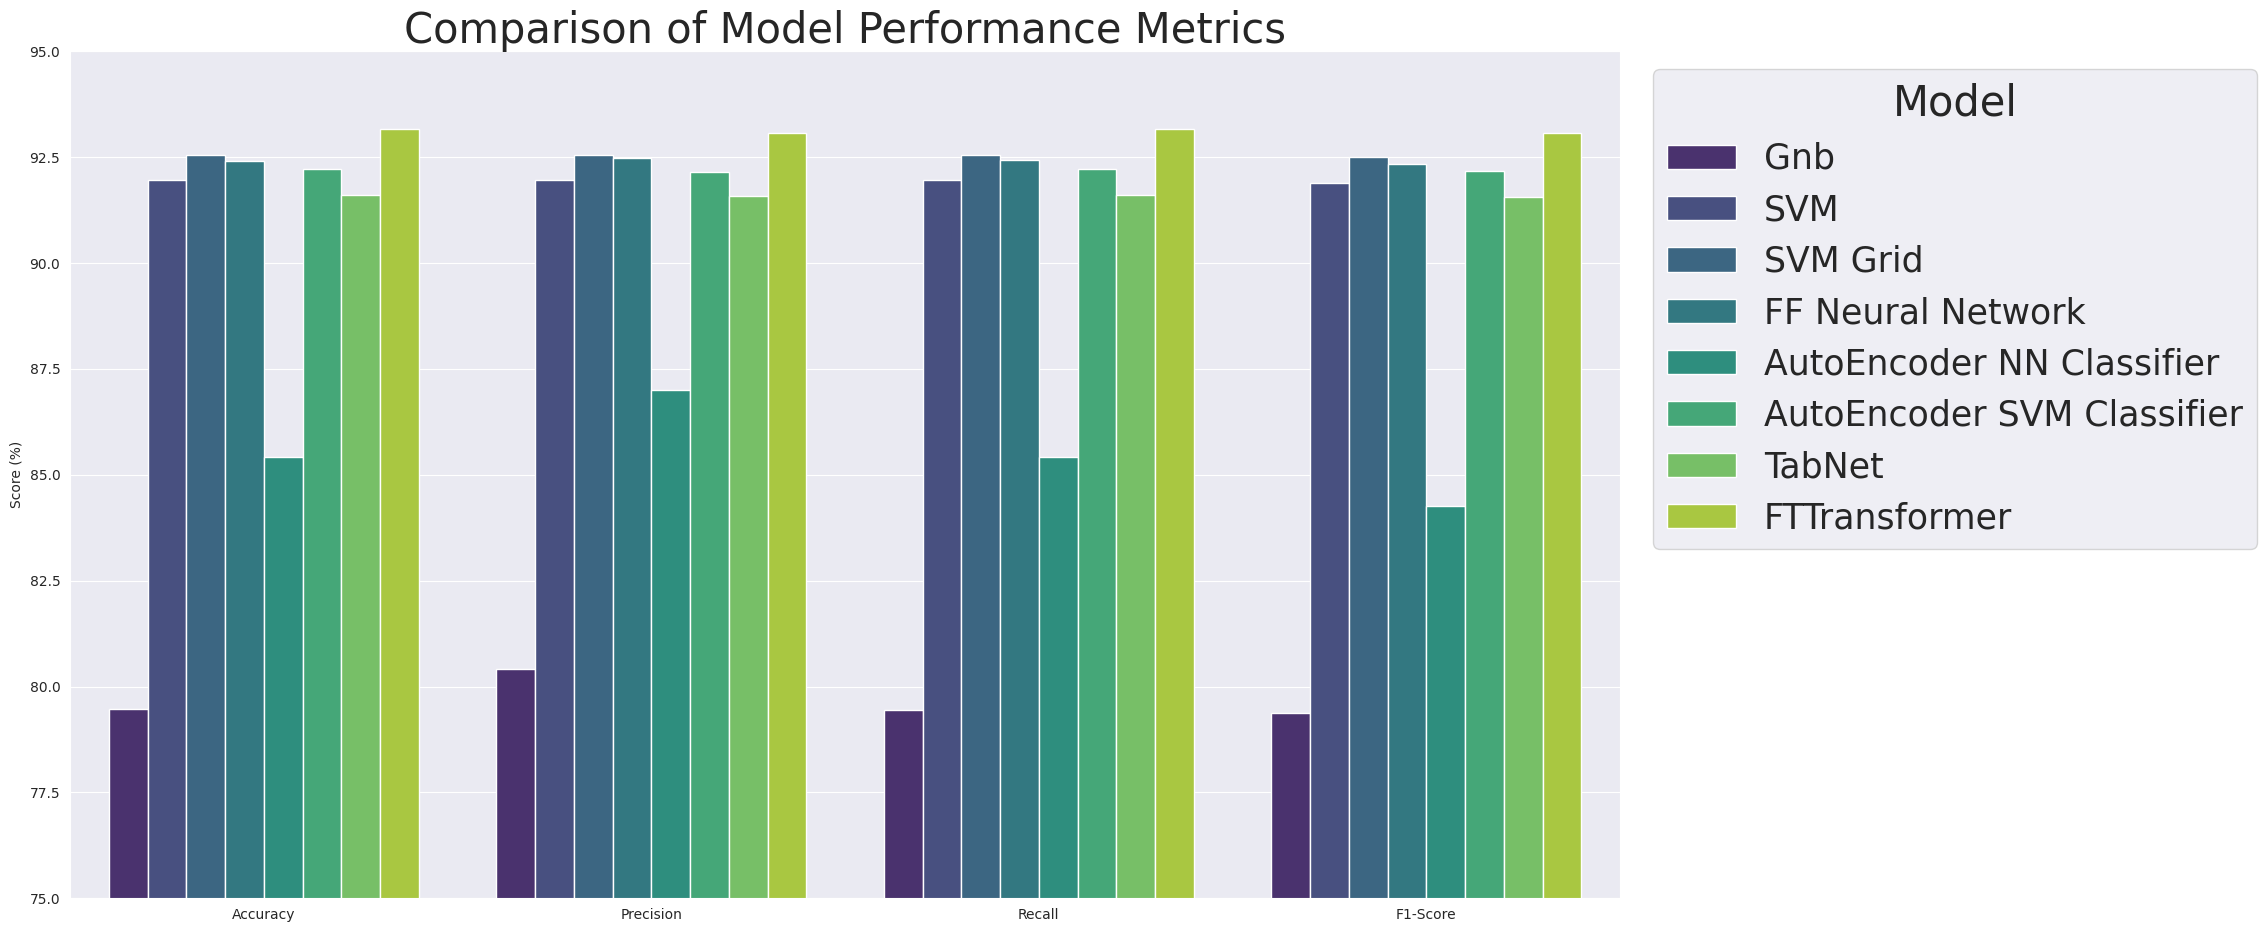

In [32]:
plt.figure(figsize=(20, 11))
plt.title('Comparison of Model Performance Metrics', fontsize=30)
sns.barplot(x='Metric', y='Score', hue='index', data=df_melted, palette='viridis')

plt.xlabel('')
plt.ylabel('Score (%)')
plt.ylim(75, 95)
legend = plt.legend(title='Model', bbox_to_anchor=(1.01, 1), loc='upper left', fontsize=25)
plt.setp(legend.get_title(), fontsize=30)

plt.show()

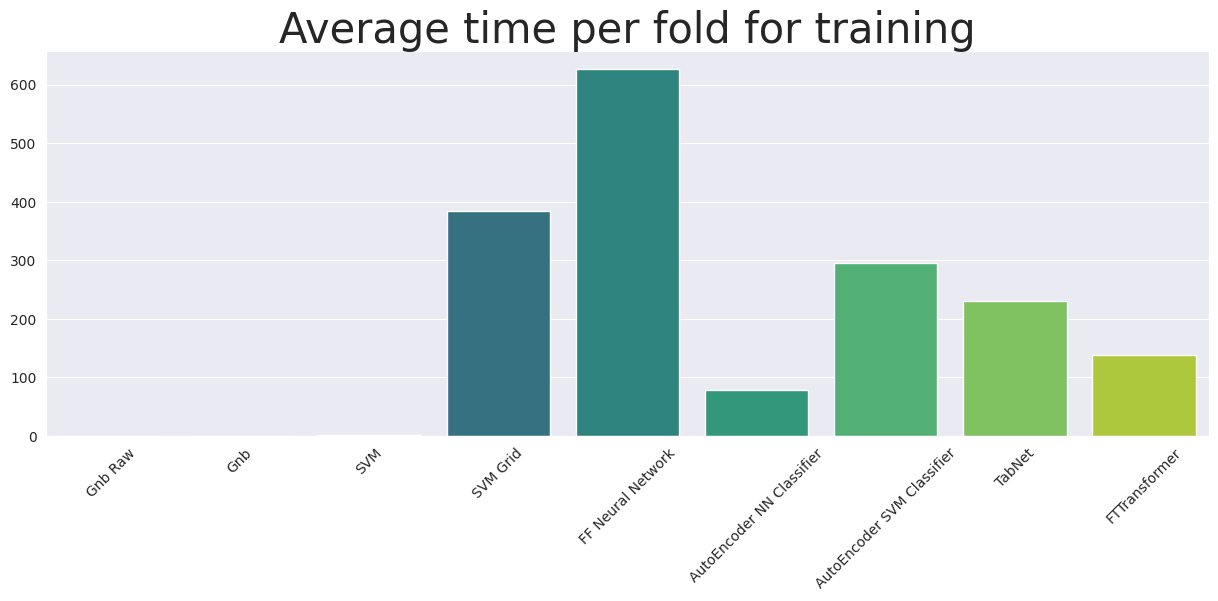

In [15]:
plt.figure(figsize=(15, 5))
plt.title('Average time per fold for training', fontsize=30)

palette = sns.color_palette('viridis', n_colors=len(time_df.T))
sns.barplot(time_df, palette=palette)
plt.yscale('linear')
plt.xticks(rotation=45)

plt.show()